In [1]:
# Cell 1: Data Loading and Setup
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
from shapely.geometry import Point, box
from pathlib import Path
import warnings
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.mask import mask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
import os
import rasterio
import warnings
from sklearn.neighbors import NearestNeighbors
# from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import box
from shapely.geometry import Point
from scipy.interpolate import griddata
from dbfread import DBF
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
COHERENCE_THRESHOLD = 0.3
NODATA = -9999
CORINE_CLASSES = {
    1: 'Continuous urban fabric',
    2: 'Discontinuous urban fabric',
    3: 'Industrial or commercial units',
    4: 'Road and rail networks',
    5: 'Port areas',
    6: 'Airports',
    7: 'Mineral extraction sites',
    8: 'Dump sites',
    9: 'Construction sites',
    10: 'Green urban areas',
    11: 'Sport and leisure facilities',
    12: 'Non-irrigated arable land',
    13: 'Permanently irrigated land',
    14: 'Rice fields',
    15: 'Vineyards',
    16: 'Fruit trees and berry plantations',
    17: 'Olive groves',
    18: 'Pastures',
    19: 'Annual crops with permanent crops',
    20: 'Complex cultivation patterns',
    21: 'Agriculture with natural vegetation',
    22: 'Agro-forestry areas',
    23: 'Broad-leaved forest',
    24: 'Coniferous forest',
    25: 'Mixed forest',
    26: 'Natural grasslands',
    27: 'Moors and heathland',
    28: 'Sclerophyllous vegetation',
    29: 'Transitional woodland-shrub',
    30: 'Beaches, dunes, sands',
    31: 'Bare rocks',
    32: 'Sparsely vegetated areas',
    33: 'Burnt areas',
    34: 'Glaciers and perpetual snow',
    35: 'Inland marshes',
    36: 'Peat bogs',
    37: 'Salt marshes',
    38: 'Salines',
    39: 'Intertidal flats',
    40: 'Water courses',
    41: 'Water bodies',
    42: 'Coastal lagoons',
    43: 'Estuaries',
    44: 'Sea and ocean'
}
CORINE_COLORS = {
    # ARTIFICIAL SURFACES (1-11) - Red/Pink/Purple tones
    1: (230, 0, 77),        # Continuous urban fabric
    2: (255, 0, 0),         # Discontinuous urban fabric
    3: (204, 77, 242),      # Industrial or commercial units
    4: (204, 0, 0),         # Road and rail networks
    5: (230, 204, 204),     # Port areas
    6: (230, 204, 230),     # Airports
    7: (166, 0, 204),       # Mineral extraction sites
    8: (166, 77, 0),        # Dump sites
    9: (255, 77, 255),      # Construction sites
    10: (255, 166, 255),    # Green urban areas
    11: (255, 230, 255),    # Sport and leisure facilities

    # AGRICULTURAL AREAS (12-22) - Yellow/Brown tones
    12: (255, 255, 168),    # Non-irrigated arable land
    13: (255, 255, 0),      # Permanently irrigated land
    14: (230, 230, 0),      # Rice fields
    15: (230, 128, 0),      # Vineyards
    16: (242, 166, 77),     # Fruit trees and berry plantations
    17: (230, 166, 0),      # Olive groves
    18: (230, 230, 77),     # Pastures
    19: (255, 230, 166),    # Annual crops with permanent crops
    20: (255, 230, 77),     # Complex cultivation patterns
    21: (230, 204, 77),     # Agriculture with natural vegetation
    22: (242, 204, 166),    # Agro-forestry areas

    # FOREST AND SEMI NATURAL AREAS (23-34) - Green tones
    23: (128, 255, 0),      # Broad-leaved forest
    24: (0, 166, 0),        # Coniferous forest
    25: (77, 255, 0),       # Mixed forest
    26: (204, 242, 77),     # Natural grasslands
    27: (166, 230, 77),     # Moors and heathland
    28: (166, 166, 230),    # Sclerophyllous vegetation
    29: (0, 204, 0),        # Transitional woodland-shrub
    30: (240, 240, 240),    # Beaches, dunes, sands
    31: (204, 204, 204),    # Bare rocks
    32: (204, 255, 204),    # Sparsely vegetated areas
    33: (0, 0, 0),          # Burnt areas
    34: (166, 230, 204),    # Glaciers and perpetual snow

    # WETLANDS (35-39) - Blue/Cyan tones
    35: (166, 166, 255),    # Inland marshes
    36: (77, 77, 255),      # Peat bogs
    37: (204, 204, 255),    # Salt marshes
    38: (230, 230, 255),    # Salines
    39: (166, 166, 230),    # Intertidal flats

    # WATER BODIES (40-44) - Dark blue tones
    40: (0, 204, 242),      # Water courses
    41: (128, 242, 230),    # Water bodies
    42: (0, 255, 166),      # Coastal lagoons
    43: (166, 255, 230),    # Estuaries
    44: (230, 242, 255)     # Sea and ocean
}

# Convert RGB (0-255) to RGB (0-1) for matplotlib
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}
print("🚀 SAOCOM Point-Based Validation Setup")
print("="*50)







🚀 SAOCOM Point-Based Validation Setup


In [2]:
# Cell 2: Data Loading and Setup
# ============================================================================
# 1. LOAD SAOCOM CSV POINTS
# ============================================================================
print("\n📍 Loading SAOCOM point data...")

saocom_files = list(DATA_DIR.glob("verona_v2*"))
if not saocom_files:
    raise FileNotFoundError("No SAOCOM CSV files found matching 'verona_v2*'")

# Load CSV with standardized column mapping
df = pd.read_csv(saocom_files[0], sep=',')
columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
df.columns = columns

# Convert to numeric and clean
for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove invalid points
df = df.dropna(subset=['LAT', 'LON', 'HEIGHT', 'COHER'])
df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

print(f"   Raw points loaded: {len(df):,}")

# Apply coherence filtering
df_filtered = df[df['COHER'] >= COHERENCE_THRESHOLD]
print(f"   Points after coherence filter (≥{COHERENCE_THRESHOLD}): {len(df_filtered):,}")
print(f"   Points removed: {len(df) - len(df_filtered):,} ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")

# Create GeoDataFrame and reproject to UTM 32N
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])]
saocom_gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs='EPSG:4326')
saocom_gdf = saocom_gdf.to_crs(TARGET_CRS)

# Add UTM coordinates
saocom_gdf['x_utm'] = saocom_gdf.geometry.x
saocom_gdf['y_utm'] = saocom_gdf.geometry.y

print(f"   ✓ SAOCOM points reprojected to {TARGET_CRS}")
print(f"   Coherence range: {df_filtered['COHER'].min():.3f} - {df_filtered['COHER'].max():.3f}")
print(f"   Height range: {df_filtered['HEIGHT'].min():.1f} - {df_filtered['HEIGHT'].max():.1f} m")




📍 Loading SAOCOM point data...
   Raw points loaded: 66,791
   Points after coherence filter (≥0.3): 66,791
   Points removed: 0 (0.0%)
   ✓ SAOCOM points reprojected to EPSG:32632
   Coherence range: 0.700 - 1.000
   Height range: -562.0 - 1163.7 m


In [3]:
# Cell 3: Data Loading and Setup
# ============================================================================
# 2. LOAD REFERENCE DEMs
# ============================================================================
print("\n🏔️  Loading reference DEMs...")

reference_dems = {}
dem_patterns = {
    'tinitaly_crop': '*tinitaly_crop*',
    'copernicus': '*GLO30*'
}

for name, pattern in dem_patterns.items():
    dem_files = list(DATA_DIR.glob(f"{pattern}.tif")) + list(DATA_DIR.glob(f"{pattern}.TIF"))

    if dem_files:
        dem_path = dem_files[0]

        # Verify DEM can be opened and get basic info
        with rasterio.open(dem_path) as src:
            print(f"   📁 {name.upper()}: {dem_path.name}")
            print(f"      CRS: {src.crs}")
            print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
            print(f"      Bounds: {src.bounds}")

            # Check if already in target CRS
            needs_reproject = str(src.crs) != TARGET_CRS
            print(f"      Needs reprojection: {needs_reproject}")

        reference_dems[name] = {
            'path': dem_path,
            'needs_reproject': needs_reproject
        }
    else:
        print(f"   ⚠️  {name.upper()}: No files found matching '{pattern}'")

print(f"\n   ✓ Found {len(reference_dems)} reference DEMs")


🏔️  Loading reference DEMs...
   ⚠️  TINITALY_CROP: No files found matching '*tinitaly_crop*'
   📁 COPERNICUS: GLO30.tif
      CRS: EPSG:4326
      Resolution: 0.0m x 0.0m
      Bounds: BoundingBox(left=11.08958332222224, bottom=45.453750011111104, right=11.229861100000017, top=45.55208334444444)
      Needs reprojection: True

   ✓ Found 1 reference DEMs


In [4]:
# # Cell 4 Addition: Process CORINE with smoothing
# from dbfread import DBF
# from scipy.ndimage import median_filter
# from rasterio.mask import mask
# from shapely.geometry import box
#
# print("\n🌍 Processing CORINE land cover data...")
#
# # Load CORINE files
# # corine_file = "lclu_crop.tif"
# corine_file = "U2018_CLC2018_V2020_20u1.tif"
#
# corine_path = DATA_DIR / corine_file
#
# if not corine_path.exists():
#     print(f"Error: {corine_file} not found")
# else:
#     print(f"✓ Found CORINE: {corine_file}")
#
#     # Load associated DBF
#     vat_dbf_path_list = list(DATA_DIR.glob(f"{corine_file}.vat.dbf"))
#     if not vat_dbf_path_list:
#         print(f"Error: .dbf file not found for {corine_file}")
#     else:
#         print('✓ DBF file found')
#         vat_dbf_path = vat_dbf_path_list[0]
#         dbf_table = DBF(vat_dbf_path, load=True)
#
#         # Create lookup table
#         lookup_df = pd.DataFrame(iter(dbf_table))
#         print(f"   DBF columns: {list(lookup_df.columns)}")
#         print(f"   Records: {len(lookup_df)}")
#
# # Get TINITALY extent for clipping
# if 'tinitaly_crop' in reference_dems:
#     with rasterio.open(reference_dems['tinitaly_crop']['path']) as tinitaly_src:
#         # Get bounds in CORINE CRS
#         tinitaly_bounds = tinitaly_src.bounds
#         if str(tinitaly_src.crs) != TARGET_CRS:
#             from rasterio.warp import transform_bounds
#             clip_bounds = transform_bounds(tinitaly_src.crs, TARGET_CRS, *tinitaly_bounds)
#         else:
#             clip_bounds = tinitaly_bounds
#
#         # Create clipping geometry
#         clip_geom = box(*clip_bounds)
#         clip_gdf = gpd.GeoDataFrame([1], geometry=[clip_geom], crs=TARGET_CRS)
#
# # Process CORINE
# with rasterio.open(corine_path) as corine_src:
#     print(f"   Original CRS: {corine_src.crs}")
#     print(f"   Original resolution: {corine_src.res[0]:.1f}m")
#
#     # Reproject clipping geometry to CORINE CRS if needed
#     if str(corine_src.crs) != TARGET_CRS:
#         clip_gdf_corine = clip_gdf.to_crs(corine_src.crs)
#     else:
#         clip_gdf_corine = clip_gdf
#
#     # Clip CORINE to study area
#     clipped_corine, clipped_transform = mask(corine_src, clip_gdf_corine.geometry, crop=True)
#     clipped_corine = clipped_corine[0]
#
#     # Filter out non-existent values using DBF
#     valid_values = set(lookup_df['Value'].values) if 'Value' in lookup_df.columns else set(lookup_df.iloc[:,0].values)
#     print(f"   Valid CORINE codes: {len(valid_values)}")
#
#     # Mask invalid values
#     valid_mask = np.isin(clipped_corine, list(valid_values))
#     clipped_corine[~valid_mask] = corine_src.nodata or 255
#
# # Resample to 10m grid
# target_width = int((clip_bounds[2] - clip_bounds[0]) / 10)
# target_height = int((clip_bounds[3] - clip_bounds[1]) / 10)
# target_transform = from_bounds(*clip_bounds, target_width, target_height)
#
# # Create 10m resampled array
# resampled_10m = np.full((target_height, target_width), 255, dtype=np.uint8)
#
# reproject(
#     source=clipped_corine,
#     destination=resampled_10m,
#     src_transform=clipped_transform,
#     src_crs=corine_src.crs,
#     dst_transform=target_transform,
#     dst_crs=TARGET_CRS,
#     resampling=Resampling.nearest
# )
#
# print(f"   ✓ Resampled to 10m: {target_width} x {target_height}")
#
# # Smooth boundaries with median filter
# print("   Smoothing boundaries...")
# smoothed_corine = median_filter(resampled_10m, size=3)
#
# # Apply additional morphological smoothing
# from scipy.ndimage import binary_opening, binary_closing
# from skimage.morphology import disk
#
# final_smooth = np.full_like(smoothed_corine, 255)
# selem = disk(1)
#
# for value in np.unique(smoothed_corine[smoothed_corine != 255]):
#     mask = (smoothed_corine == value)
#     opened = binary_opening(mask, selem)
#     closed = binary_closing(opened, selem)
#     final_smooth[closed] = value
#
# # Save smoothed CORINE
# corine_output_path = RESULTS_DIR / "corine_10m_smoothed.tif"
# profile = {
#     'driver': 'GTiff', 'dtype': 'uint8', 'width': target_width, 'height': target_height,
#     'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
#     'nodata': 255, 'compress': 'lzw'
# }
#
# with rasterio.open(corine_output_path, 'w', **profile) as dst:
#     dst.write(final_smooth, 1)
#
# print(f"   ✓ Saved: {corine_output_path.name}")
#
# # Display the smoothed result
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#
# # Original blocky
# ax1.imshow(resampled_10m, extent=clip_bounds, cmap='tab20', origin='lower')
# ax1.set_title('10m Nearest Neighbor\n(Blocky)')
# ax1.set_xlabel('UTM Easting (m)')
# ax1.set_ylabel('UTM Northing (m)')
#
# # Smoothed
# im2 = ax2.imshow(final_smooth, extent=clip_bounds, cmap='tab20', origin='lower')
# ax2.set_title('10m Smoothed Boundaries\n(Organic)')
# ax2.set_xlabel('UTM Easting (m)')
# ax2.set_ylabel('UTM Northing (m)')
#
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'corine_smoothing_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()
#
# # Update corine_data for later use
# corine_data = {
#     'path': corine_output_path,
#     'type': 'raster_smoothed',
#     'lookup_table': {'lookup_df': lookup_df},
#     'is_10m': True,
#     'needs_reproject': False
# }
#
# print("✅ CORINE processing complete!")

In [5]:
# Cell 5: SUMMARY AND STUDY AREA BOUNDS
# ============================================================================
# 4. SUMMARY AND STUDY AREA BOUNDS
# ============================================================================
print("\n📏 Study area summary...")

# Get study area bounds from SAOCOM points
study_bounds = saocom_gdf.total_bounds
xmin, ymin, xmax, ymax = study_bounds

print(f"   Study area bounds (UTM 32N):")
print(f"      X: {xmin:,.0f} - {xmax:,.0f} m")
print(f"      Y: {ymin:,.0f} - {ymax:,.0f} m")
print(f"      Width: {(xmax-xmin)/1000:.1f} km")
print(f"      Height: {(ymax-ymin)/1000:.1f} km")

# Create study area polygon for clipping
study_area_poly = box(xmin, ymin, xmax, ymax)
study_area_gdf = gpd.GeoDataFrame([1], geometry=[study_area_poly], crs=TARGET_CRS)

print(f"\n✅ Data loading complete!")
print(f"   SAOCOM points: {len(saocom_gdf):,}")
print(f"   Reference DEMs: {len(reference_dems)}")
# print(f"   Land cover: {'✓' if corine_data else '✗'}")
print(f"   All data will be processed in {TARGET_CRS}")

# Store key variables for next cells
loaded_data = {
    'saocom_gdf': saocom_gdf,
    'reference_dems': reference_dems,
    'study_bounds': study_bounds,
    'study_area_gdf': study_area_gdf,
    'coherence_threshold': COHERENCE_THRESHOLD
}

print(f"\n📋 Ready for Cell 2: Spatial Coverage Analysis")



📏 Study area summary...
   Study area bounds (UTM 32N):
      X: 664,943 - 674,223 m
      Y: 5,037,632 - 5,045,391 m
      Width: 9.3 km
      Height: 7.8 km

✅ Data loading complete!
   SAOCOM points: 66,791
   Reference DEMs: 1
   All data will be processed in EPSG:32632

📋 Ready for Cell 2: Spatial Coverage Analysis


In [6]:
# Cell 6 - Resample and Mask Reference DEMs
# ===========================================================================
# 5. RESAMPLE & MASK REFERENCE DEMs TO 10m GRID
# ===========================================================================
import geopandas as gpd
from rasterio import features

print("\n🔧 Resampling and Masking reference DEMs to 10m grid...")

# Use study area bounds from SAOCOM for consistent grid
xmin_grid = np.floor(study_bounds[0] / 10) * 10
ymin_grid = np.floor(study_bounds[1] / 10) * 10
xmax_grid = np.ceil(study_bounds[2] / 10) * 10
ymax_grid = np.ceil(study_bounds[3] / 10) * 10

# Calculate grid dimensions and transform
width = int((xmax_grid - xmin_grid) / 10)
height = int((ymax_grid - ymin_grid) / 10)
target_transform = rasterio.transform.from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, width, height)

# ===========================================================================
# (NEW) CREATE CONVEX HULL FROM SAOCOM POINTS TO USE AS A MASK
# ===========================================================================
print("   Creating convex hull from SAOCOM points to use as a mask...")
data_hull = saocom_gdf.unary_union.convex_hull

resampled_dems = {}

for name, dem_info in reference_dems.items():
    print(f"   Processing {name.upper()}...")

    output_path = RESULTS_DIR / f"{name}_10m_resampled_masked.tif"

    with rasterio.open(dem_info['path']) as src:
        # Create output array
        output_array = np.full((height, width), NODATA, dtype=np.float32)

        # Reproject to 10m grid
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata,
            dst_nodata=NODATA
        )

        # ===================================================================
        # (NEW) MASK THE RESAMPLED DEM TO THE HULL
        # ===================================================================
        # Rasterize the hull polygon into a boolean mask with the same shape as our output array.
        hull_mask = features.rasterize(
            shapes=[data_hull],
            out_shape=output_array.shape,
            transform=target_transform,
            fill=0,      # background value
            all_touched=True,
            dtype=np.uint8
        ) == 1 # Convert to boolean (True inside the hull)

        # Apply the mask: where the mask is False (outside the hull), set array values to NODATA
        output_array[~hull_mask] = NODATA
        # ===================================================================

        # Save resampled and masked DEM
        profile = {
            'driver': 'GTiff', 'dtype': 'float32', 'width': width, 'height': height,
            'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
            'nodata': NODATA, 'compress': 'lzw'
        }

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)

        # Verify resampling
        valid_pixels = np.sum(output_array != NODATA)
        print(f"      ✓ Saved masked file: {output_path.name}")
        print(f"      Dimensions: {width} x {height}")
        print(f"      Valid pixels after masking: {valid_pixels:,}")

    resampled_dems[name] = output_path

print(f"\n✅ All reference DEMs resampled and masked to the SAOCOM footprint!")

# Update the reference_dems dict to point to resampled/masked versions
for name in reference_dems.keys():
    reference_dems[name]['resampled_path'] = resampled_dems[name]
    reference_dems[name]['is_10m'] = True

# Update loaded_data
loaded_data.update({
    'resampled_dems': resampled_dems,
    'target_transform': target_transform,
    'grid_bounds_10m': (xmin_grid, ymin_grid, xmax_grid, ymax_grid)
})
available_refs = list(reference_dems.keys())


🔧 Resampling and Masking reference DEMs to 10m grid...
   Creating convex hull from SAOCOM points to use as a mask...
   Processing COPERNICUS...
      ✓ Saved masked file: copernicus_10m_resampled_masked.tif
      Dimensions: 929 x 777
      Valid pixels after masking: 520,963

✅ All reference DEMs resampled and masked to the SAOCOM footprint!


In [7]:
# # Cell 6.5: Vertical Datum Harmonization - Convert Copernicus from EGM2008 to WGS84
# import numpy as np
# import rasterio
# from rasterio.warp import reproject, Resampling
# import requests
# from scipy.interpolate import RectBivariateSpline
# import pandas as pd
#
# print("🌐 VERTICAL DATUM HARMONIZATION")
# print("="*50)
# print("Converting Copernicus from EGM2008 geoid to WGS84 ellipsoid")
#
# # ============================================================================
# # 1. VERIFY CURRENT VERTICAL DATUMS
# # ============================================================================
# print("\n📋 Verifying vertical datums of reference DEMs...")
#
# for name, dem_info in reference_dems.items():
#     if 'resampled_path' in dem_info:
#         with rasterio.open(dem_info['resampled_path']) as src:
#             print(f"\n{name.upper()}:")
#             print(f"   CRS: {src.crs}")
#
#             # Check if vertical datum info is in the CRS
#             wkt = src.crs.to_wkt()
#             if 'VERT_CS' in wkt or 'VERTCS' in wkt:
#                 print("   Vertical datum found in metadata:")
#                 for line in wkt.split('\n'):
#                     if 'VERT' in line:
#                         print(f"      {line.strip()}")
#             else:
#                 print("   No explicit vertical datum in metadata")
#                 if name == 'tinitaly_crop':
#                     print("   → Assuming WGS84 ellipsoid (typical for TINITALY)")
#                 elif name == 'copernicus':
#                     print("   → Copernicus GLO-30 uses EGM2008 geoid (documented)")
#
# # ============================================================================
# # 2. CALCULATE GEOID UNDULATION FOR THE STUDY AREA
# # ============================================================================
# print("\n🔢 Calculating EGM2008 geoid undulation for study area...")
#
# # Method 1: Use approximate formula for Italy region
# # For more precision, you could download the full EGM2008 grid
# def calculate_egm2008_undulation_approximate(lon, lat):
#     """
#     Approximate EGM2008 geoid undulation for Northern Italy
#     Real values vary from ~43-52m in this region
#     """
#     # For Verona area (45.4°N, 11°E), typical undulation is ~47-48m
#     # This is simplified - for production, use the full EGM2008 model
#     base_undulation = 47.5  # meters for Verona region
#
#     # Small variations based on location (simplified)
#     lat_factor = (lat - 45.0) * 0.5
#     lon_factor = (lon - 11.0) * 0.3
#
#     return base_undulation + lat_factor + lon_factor
#
# # Get study area center coordinates
# with rasterio.open(reference_dems['copernicus']['resampled_path']) as src:
#     bounds = src.bounds
#     center_x = (bounds.left + bounds.right) / 2
#     center_y = (bounds.bottom + bounds.top) / 2
#
#     # Transform to lat/lon if needed
#     if str(src.crs).startswith('EPSG:326'):  # UTM zone 32/33
#         from pyproj import Transformer
#         transformer = Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
#         center_lon, center_lat = transformer.transform(center_x, center_y)
#     else:
#         center_lon, center_lat = center_x, center_y
#
# print(f"   Study area center: {center_lat:.4f}°N, {center_lon:.4f}°E")
#
# # Calculate undulation at center
# undulation_center = calculate_egm2008_undulation_approximate(center_lon, center_lat)
# print(f"   Approximate EGM2008 undulation: {undulation_center:.1f} m")
#
# # ============================================================================
# # 3. OPTION A: SIMPLE CONSTANT SHIFT (Good enough for small areas)
# # ============================================================================
# print("\n🔧 Applying vertical datum correction to Copernicus...")
# print(f"   Method: Adding constant {undulation_center:.1f}m to convert EGM2008 → WGS84")
#
# # Load Copernicus DEM
# copernicus_path = reference_dems['copernicus']['resampled_path']
# output_path = RESULTS_DIR / 'copernicus_10m_wgs84.tif'
#
# with rasterio.open(copernicus_path) as src:
#     copernicus_egm2008 = src.read(1).astype(np.float32)
#     profile = src.profile.copy()
#
#     # Apply correction: WGS84 ellipsoid = EGM2008 geoid + undulation
#     copernicus_wgs84 = np.where(
#         copernicus_egm2008 != src.nodata,
#         copernicus_egm2008 + undulation_center,
#         src.nodata
#     )
#
#     # Statistics before and after
#     valid_mask = copernicus_egm2008 != src.nodata
#     if valid_mask.any():
#         print(f"\n   Before correction (EGM2008):")
#         print(f"      Mean elevation: {copernicus_egm2008[valid_mask].mean():.1f} m")
#         print(f"      Range: {copernicus_egm2008[valid_mask].min():.1f} - {copernicus_egm2008[valid_mask].max():.1f} m")
#
#         print(f"\n   After correction (WGS84):")
#         print(f"      Mean elevation: {copernicus_wgs84[valid_mask].mean():.1f} m")
#         print(f"      Range: {copernicus_wgs84[valid_mask].min():.1f} - {copernicus_wgs84[valid_mask].max():.1f} m")
#         print(f"      Shift applied: +{undulation_center:.1f} m")
#
# # Save corrected Copernicus DEM
# with rasterio.open(output_path, 'w', **profile) as dst:
#     dst.write(copernicus_wgs84, 1)
#
# print(f"\n✅ Saved WGS84-corrected Copernicus: {output_path.name}")
#
# # Update reference_dems to use corrected version
# reference_dems['copernicus']['resampled_path'] = output_path
# reference_dems['copernicus']['datum_corrected'] = True
# reference_dems['copernicus']['vertical_datum'] = 'WGS84'
#
# # ============================================================================
# # 4. OPTION B: SPATIALLY-VARYING CORRECTION (More accurate for large areas)
# # ============================================================================
# print("\n📍 For more accuracy over large areas, use spatially-varying undulation:")
# print("   (Currently using constant shift, which is sufficient for ~70km area)")
#
# # Code for spatially-varying correction (commented out for simplicity)
# """
# # Create undulation grid for the study area
# x_coords = np.linspace(bounds.left, bounds.right, 50)
# y_coords = np.linspace(bounds.bottom, bounds.top, 50)
# x_grid, y_grid = np.meshgrid(x_coords, y_coords)
#
# # Transform to lat/lon
# transformer = Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
# lon_grid, lat_grid = transformer.transform(x_grid.ravel(), y_grid.ravel())
#
# # Calculate undulation at each point
# undulation_grid = np.array([
#     calculate_egm2008_undulation_approximate(lon, lat)
#     for lon, lat in zip(lon_grid, lat_grid)
# ]).reshape(x_grid.shape)
#
# # Interpolate to DEM resolution
# interp = RectBivariateSpline(y_coords, x_coords, undulation_grid)
#
# # Apply spatially-varying correction
# rows, cols = np.indices(copernicus_egm2008.shape)
# x_dem = bounds.left + cols * src.res[0]
# y_dem = bounds.top - rows * src.res[1]
# undulation_dem = interp(y_dem.ravel(), x_dem.ravel(), grid=False).reshape(copernicus_egm2008.shape)
#
# copernicus_wgs84_varying = np.where(
#     copernicus_egm2008 != src.nodata,
#     copernicus_egm2008 + undulation_dem,
#     src.nodata
# )
# """
#
# # ============================================================================
# # 5. VERIFY THE CORRECTION IMPACT
# # ============================================================================
# print("\n🔍 Expected impact on SAOCOM validation:")
# print(f"   Previous bias (SAOCOM - Copernicus): likely ~-2m")
# print(f"   Datum correction applied: +{undulation_center:.1f}m")
# print(f"   Expected new bias: ~{-2 + undulation_center:.1f}m")
# print("\n   Note: The remaining bias after correction reveals true SAOCOM characteristics")
# print("   (e.g., vegetation penetration, processing artifacts, etc.)")
#
# # ============================================================================
# # 6. FOR PRODUCTION: Download actual EGM2008 grid
# # ============================================================================
# print("\n📚 For production use, download the actual EGM2008 geoid model:")
# print("   1. Download from: https://earth-info.nga.mil/GandG/wgs84/gravitymod/egm2008/")
# print("   2. Use pygeoid library: pip install pygeoid")
# print("   3. Or use GDAL/PROJ with the geoid grid files")
#
# print("\n✅ Vertical datum harmonization complete!")
# print("   All DEMs now referenced to WGS84 ellipsoid")
# print("   Re-run validation cells to see corrected statistics")

In [8]:
# Cell 7: Spatial Coverage Analysis (Corrected with Convex Hull Mask)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import seaborn as sns
from collections import Counter
import geopandas as gpd

print("🗺️  SPATIAL COVERAGE ANALYSIS (Masked to Data Footprint)")
print("="*50)

# Configuration for grid analysis
GRID_SIZE = 10  # meters
print(f"Grid cell size: {GRID_SIZE}m x {GRID_SIZE}m")

# ===========================================================================
# 1. CREATE INITIAL RECTANGULAR GRID
# ===========================================================================
print("\n📐 Creating initial rectangular study area grid...")
xmin, ymin, xmax, ymax = study_bounds
x_coords = np.arange(xmin, xmax + GRID_SIZE, GRID_SIZE)
y_coords = np.arange(ymin, ymax + GRID_SIZE, GRID_SIZE)
x_centers = x_coords[:-1] + GRID_SIZE/2
y_centers = y_coords[:-1] + GRID_SIZE/2
grid_x, grid_y = np.meshgrid(x_centers, y_centers)
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

# Create a dataframe for the full rectangular grid
full_grid_df = pd.DataFrame({
    'grid_id': np.arange(len(grid_points)),
    'x_center': grid_points[:, 0],
    'y_center': grid_points[:, 1]
})

# ===========================================================================
# 2. (NEW) CREATE CONVEX HULL AND MASK THE GRID
# ===========================================================================
print("\n⭐ Masking grid to the actual data footprint using a convex hull...")
# Create a hull polygon around the data points
data_hull = saocom_gdf.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[data_hull], crs=TARGET_CRS)

# Convert the full grid to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    full_grid_df,
    geometry=gpd.points_from_xy(full_grid_df.x_center, full_grid_df.y_center),
    crs=TARGET_CRS
)

# Keep only the grid cells that fall WITHIN the data hull
grid_df = gpd.sjoin(grid_gdf, hull_gdf, how="inner", predicate="within").drop(columns=['index_right'])
print(f"   Original rectangular grid cells: {len(full_grid_df):,}")
print(f"   Masked grid cells for analysis: {len(grid_df):,}")


# ===========================================================================
# 3. MAP SAOCOM POINTS TO THE MASKED GRID
# ===========================================================================
print("\n📍 Mapping SAOCOM points to the masked grid cells...")
# Initialize columns for the analysis
grid_df['n_saocom_points'] = 0
grid_df['has_saocom'] = False

# Use a faster method: assign each SAOCOM point to a grid cell
# Calculate grid indices for each SAOCOM point
saocom_x = saocom_gdf.geometry.x.values
saocom_y = saocom_gdf.geometry.y.values
col_indices = np.floor((saocom_x - xmin) / GRID_SIZE).astype(int)
row_indices = np.floor((saocom_y - ymin) / GRID_SIZE).astype(int)

# Count points in each grid cell (this is much faster than BallTree for this task)
point_counts = pd.DataFrame({'x': saocom_x, 'y': saocom_y}).groupby([
    np.floor((saocom_y - ymin) / GRID_SIZE),
    np.floor((saocom_x - xmin) / GRID_SIZE)
]).size().to_dict()

# Map these counts back to our grid_df
grid_df_rows = np.floor((grid_df.y_center - ymin) / GRID_SIZE)
grid_df_cols = np.floor((grid_df.x_center - xmin) / GRID_SIZE)
grid_df['n_saocom_points'] = [point_counts.get((r, c), 0) for r, c in zip(grid_df_rows, grid_df_cols)]
grid_df['has_saocom'] = grid_df['n_saocom_points'] > 0


# ===========================================================================
# 4. IDENTIFY VOID CELLS (NOW USING CORRECTED TOTALS)
# ===========================================================================
print("\n🕳️  Identifying void cells within the data footprint...")
n_total_cells = len(grid_df) # This is now the corrected total
n_occupied_cells = np.sum(grid_df['has_saocom'])
n_void_cells = n_total_cells - n_occupied_cells
void_percentage = 100 * n_void_cells / n_total_cells if n_total_cells > 0 else 0

print(f"   Total grid cells (in hull): {n_total_cells:,}")
print(f"   Cells with SAOCOM data: {n_occupied_cells:,}")
print(f"   Void cells: {n_void_cells:,}")
print(f"   ✅ Corrected Void Percentage: {void_percentage:.1f}%")

# Store results for next cells
coverage_analysis = {
    'grid_df': grid_df, # This is the MASKED dataframe
    'full_grid_df': full_grid_df, # The original rectangular grid for plotting
    'grid_shape': grid_x.shape,
    'grid_bounds': (xmin_grid, ymin_grid, xmax_grid, ymax_grid),
    'void_percentage': void_percentage,
    'n_total_cells': n_total_cells,
    'n_occupied_cells': n_occupied_cells,
    'n_void_cells': n_void_cells
}

print(f"\n✅ Coverage analysis complete!")

# ============================================================================
# 4. EXTRACT LAND COVER FOR GRID CELLS (if available)
# ============================================================================
# Updated CORINE extraction for Cell 2:
#
# if corine_data is not None:
#     print("\n🌱 Extracting land cover for 10m grid cells...")
#
#     if corine_data['type'] == 'raster_smoothed':
#         # Extract from smoothed 10m raster (already in correct CRS and resolution)
#         with rasterio.open(corine_data['path']) as src:
#             print(f"      Using smoothed 10m CORINE raster")
#
#             # Sample land cover at grid points
#             coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
#             land_cover_values = list(src.sample(coords))
#             raw_values = [val[0] if val[0] != src.nodata else np.nan for val in land_cover_values]
#
#             # Apply lookup table if available to get CORINE codes/labels
#             if 'lookup_table' in corine_data and 'lookup_df' in corine_data['lookup_table']:
#                 lookup_df = corine_data['lookup_table']['lookup_df']
#                 print(f"      Applying lookup table with {len(lookup_df)} entries")
#
#                 # Create value-to-code mapping from DBF
#                 if 'Value' in lookup_df.columns and 'CLC_CODE' in lookup_df.columns:
#                     value_to_code = dict(zip(lookup_df['Value'], lookup_df['CLC_CODE']))
#                     corine_codes = [value_to_code.get(val, np.nan) if not pd.isna(val) else np.nan
#                                    for val in raw_values]
#                     grid_df['land_cover'] = corine_codes
#                     grid_df['land_cover_raw'] = raw_values
#
#                     # Also get labels if availableF
#                     if 'LABEL3' in lookup_df.columns:
#                         value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
#                         grid_df['land_cover_label'] = [value_to_label.get(val, 'Unknown') if not pd.isna(val) else 'No Data'
#                                                       for val in raw_values]
#
#                     print(f"      ✓ Mapped to CORINE codes using lookup table")
#                 else:
#                     # Use raw values if lookup structure is different
#                     grid_df['land_cover'] = raw_values
#                     print(f"      Using raw raster values (lookup columns not found)")
#             else:
#                 grid_df['land_cover'] = raw_values
#                 print(f"      Using raw raster values (no lookup table)")
#
#     elif corine_data['type'] == 'raster':
#         # Original raster handling (if needed)
#         with rasterio.open(corine_data['path']) as src:
#             if corine_data['needs_reproject']:
#                 print("      (Reprojecting CORINE on-the-fly)")
#
#             coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
#             land_cover_values = list(src.sample(coords))
#             grid_df['land_cover'] = [val[0] if val[0] != src.nodata else np.nan for val in land_cover_values]
#
#     elif corine_data['type'] == 'vector':
#         # Spatial join with vector data
#         grid_geometry = [Point(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
#         grid_gdf = gpd.GeoDataFrame(grid_df, geometry=grid_geometry, crs=TARGET_CRS)
#
#         if corine_data['needs_reproject']:
#             corine_reproj = corine_data['gdf'].to_crs(TARGET_CRS)
#         else:
#             corine_reproj = corine_data['gdf']
#
#         # Assuming land cover code is in a column like 'CODE_18' or 'code'
#         lc_columns = [col for col in corine_reproj.columns if 'code' in col.lower()]
#         if lc_columns:
#             lc_col = lc_columns[0]
#             joined = gpd.sjoin(grid_gdf, corine_reproj[[lc_col, 'geometry']], how='left', predicate='within')
#             grid_df['land_cover'] = joined[lc_col].values
#         else:
#             print("      Warning: No land cover code column found")
#             grid_df['land_cover'] = np.nan
#
#     # Calculate void percentage by land cover class
#     print("\n   Void percentage by land cover class (top 10):")
#
#     valid_lc = grid_df['land_cover'].dropna()
#     if len(valid_lc) > 0:
#         lc_void_stats = grid_df.groupby('land_cover').agg({
#             'has_saocom': ['count', 'sum'],
#             'n_saocom_points': 'sum'
#         })
#
#         lc_void_stats.columns = ['total_cells', 'occupied_cells', 'total_points']
#         lc_void_stats['void_cells'] = lc_void_stats['total_cells'] - lc_void_stats['occupied_cells']
#         lc_void_stats['void_percentage'] = 100 * lc_void_stats['void_cells'] / lc_void_stats['total_cells']
#         lc_void_stats = lc_void_stats.sort_values('total_cells', ascending=False).head(10)
#
#         # Add land cover labels if available
#         if 'land_cover_label' in grid_df.columns:
#             # Get most common label for each code
#             code_to_label = grid_df.groupby('land_cover')['land_cover_label'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown')
#             lc_void_stats['label'] = lc_void_stats.index.map(code_to_label)
#             print(lc_void_stats[['total_cells', 'void_percentage', 'label']].round(1))
#         else:
#             print(lc_void_stats[['total_cells', 'void_percentage']].round(1))
#
#         print(f"      ✓ Extracted land cover for {len(valid_lc):,} grid cells")
#     else:
#         print("      No valid land cover data extracted")
#
# else:
#     print("\n⚠️  No CORINE data available - skipping land cover analysis")
#     grid_df['land_cover'] = np.nan


🗺️  SPATIAL COVERAGE ANALYSIS (Masked to Data Footprint)
Grid cell size: 10m x 10m

📐 Creating initial rectangular study area grid...

⭐ Masking grid to the actual data footprint using a convex hull...
   Original rectangular grid cells: 720,904
   Masked grid cells for analysis: 519,258

📍 Mapping SAOCOM points to the masked grid cells...

🕳️  Identifying void cells within the data footprint...
   Total grid cells (in hull): 519,258
   Cells with SAOCOM data: 64,104
   Void cells: 455,154
   ✅ Corrected Void Percentage: 87.7%

✅ Coverage analysis complete!


In [9]:
# Cell 8: TERRAIN CHARACTERISTICS (if reference DEMs available)
# ============================================================================
# 5. TERRAIN CHARACTERISTICS (if reference DEMs available)
# ============================================================================


if 'tinitaly' in reference_dems:
    print("\n⛰️  Extracting terrain characteristics...")

    with rasterio.open(reference_dems['tinitaly']['path']) as src:
        # Sample elevation at grid points
        coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
        elevation_values = list(src.sample(coords))
        grid_df['elevation'] = [val[0] if val[0] != src.nodata else np.nan for val in elevation_values]

    # Create elevation bins for analysis
    valid_elevations = grid_df['elevation'].dropna()
    if len(valid_elevations) > 0:
        elevation_bins = pd.qcut(valid_elevations, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        grid_df['elevation_bin'] = pd.qcut(grid_df['elevation'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

        # Void percentage by elevation
        print("\n   Void percentage by elevation bin:")
        elev_void_stats = grid_df.groupby('elevation_bin').agg({
            'has_saocom': ['count', 'sum']
        })
        elev_void_stats.columns = ['total_cells', 'occupied_cells']
        elev_void_stats['void_percentage'] = 100 * (elev_void_stats['total_cells'] - elev_void_stats['occupied_cells']) / elev_void_stats['total_cells']
        print(elev_void_stats)

In [10]:
# Cell 9: Point-to-Pixel Extraction
import numpy as np
import pandas as pd
import rasterio
from pathlib import Path

print("🎯 POINT-TO-PIXEL EXTRACTION")
print("="*50)
print("Extracting reference DEM values at exact SAOCOM coordinates (NO INTERPOLATION)")

# ============================================================================
# 1. SETUP EXTRACTION COORDINATES
# ============================================================================
print("\n📍 Preparing SAOCOM point coordinates...")

# Use SAOCOM points from previous analysis
saocom_coords = list(zip(saocom_gdf['x_utm'], saocom_gdf['y_utm']))
n_points = len(saocom_coords)

print(f"   SAOCOM points to process: {n_points:,}")
print(f"   Coordinate range:")
print(f"      X: {saocom_gdf['x_utm'].min():,.0f} - {saocom_gdf['x_utm'].max():,.0f} m")
print(f"      Y: {saocom_gdf['y_utm'].min():,.0f} - {saocom_gdf['y_utm'].max():,.0f} m")

# Create master dataframe starting with SAOCOM data
master_df = saocom_gdf[['x_utm', 'y_utm', 'HEIGHT', 'COHER']].copy()
master_df = master_df.rename(columns={
    'x_utm': 'x',
    'y_utm': 'y',
    'HEIGHT': 'saocom_height',
    'COHER': 'coherence'
})

print(f"   ✓ Master dataframe initialized with {len(master_df)} points")

# ============================================================================
# 2. EXTRACT TINITALY ELEVATIONS
# ============================================================================
if 'tinitaly_crop' in reference_dems and 'resampled_path' in reference_dems['tinitaly_crop']:
    print("\n🏔️  Extracting TINITALY elevations...")

    tinitaly_path = reference_dems['tinitaly_crop']['resampled_path']

    with rasterio.open(tinitaly_path) as src:
        print(f"      Source: {tinitaly_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values at SAOCOM coordinates
        tinitaly_values = list(src.sample(saocom_coords))
        tinitaly_heights = [val[0] if val[0] != src.nodata else np.nan for val in tinitaly_values]

        # Add to master dataframe
        master_df['tinitaly_height'] = tinitaly_heights

        # Quality check
        valid_tinitaly = np.sum(~np.isnan(tinitaly_heights))
        print(f"      ✓ Extracted {valid_tinitaly:,} valid values ({100*valid_tinitaly/n_points:.1f}%)")

        if valid_tinitaly > 0:
            valid_data = [h for h in tinitaly_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  TINITALY not available - skipping")
    master_df['tinitaly_height'] = np.nan

# ============================================================================
# 3. EXTRACT COPERNICUS ELEVATIONS
# ============================================================================
if 'copernicus' in reference_dems and 'resampled_path' in reference_dems['copernicus']:
    print("\n🌍 Extracting Copernicus elevations...")

    copernicus_path = reference_dems['copernicus']['resampled_path']

    with rasterio.open(copernicus_path) as src:
        print(f"      Source: {copernicus_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values
        copernicus_values = list(src.sample(saocom_coords))
        copernicus_heights = [val[0] if val[0] != src.nodata else np.nan for val in copernicus_values]

        # Add to master dataframe
        master_df['copernicus_height'] = copernicus_heights

        # Quality check
        valid_copernicus = np.sum(~np.isnan(copernicus_heights))
        print(f"      ✓ Extracted {valid_copernicus:,} valid values ({100*valid_copernicus/n_points:.1f}%)")

        if valid_copernicus > 0:
            valid_data = [h for h in copernicus_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  Copernicus not available - skipping")
    master_df['copernicus_height'] = np.nan

# ============================================================================
# 4. EXTRACT LIDAR ELEVATIONS (if available)
# ============================================================================
if 'lidar' in reference_dems and 'resampled_path' in reference_dems['lidar']:
    print("\n📡 Extracting LiDAR elevations...")

    lidar_path = reference_dems['lidar']['resampled_path']

    with rasterio.open(lidar_path) as src:
        print(f"      Source: {lidar_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values
        lidar_values = list(src.sample(saocom_coords))
        lidar_heights = [val[0] if val[0] != src.nodata else np.nan for val in lidar_values]

        # Add to master dataframe
        master_df['lidar_height'] = lidar_heights

        # Quality check
        valid_lidar = np.sum(~np.isnan(lidar_heights))
        print(f"      ✓ Extracted {valid_lidar:,} valid values ({100*valid_lidar/n_points:.1f}%)")

        if valid_lidar > 0:
            valid_data = [h for h in lidar_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  LiDAR not available - skipping")
    master_df['lidar_height'] = np.nan

# ============================================================================
# 5. EXTRACT CORINE LAND COVER
# ============================================================================
# if corine_data is not None and 'path' in corine_data:
#     print("\n🌱 Extracting CORINE land cover...")
#
#     with rasterio.open(corine_data['path']) as src:
#         print(f"      Source: {corine_data['path'].name}")
#         print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
#         print(f"      NoData: {src.nodata}")
#
#         # Extract exact pixel values
#         corine_values = list(src.sample(saocom_coords))
#         corine_raw = [val[0] if val[0] != src.nodata else np.nan for val in corine_values]
#
#         # Apply lookup table if available
#         if 'lookup_table' in corine_data and 'lookup_df' in corine_data['lookup_table']:
#             lookup_df = corine_data['lookup_table']['lookup_df']
#
#             # Map raw values to CORINE codes
#             if 'Value' in lookup_df.columns and 'CLC_CODE' in lookup_df.columns:
#                 value_to_code = dict(zip(lookup_df['Value'], lookup_df['CLC_CODE']))
#                 corine_codes = [value_to_code.get(val, np.nan) if not pd.isna(val) else np.nan for val in corine_raw]
#                 master_df['land_cover'] = corine_codes
#                 master_df['land_cover_raw'] = corine_raw
#
#                 # Also get labels if available
#                 if 'LABEL3' in lookup_df.columns:
#                     value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
#                     master_df['land_cover_label'] = [value_to_label.get(val, 'Unknown') if not pd.isna(val) else 'No Data' for val in corine_raw]
#
#                 print(f"      ✓ Applied lookup table mapping")
#             else:
#                 master_df['land_cover'] = corine_raw
#                 print(f"      Using raw raster values")
#         else:
#             master_df['land_cover'] = corine_raw
#             print(f"      Using raw raster values")
#
#         # Quality check
#         valid_corine = np.sum(~np.isnan(master_df['land_cover']))
#         print(f"      ✓ Extracted {valid_corine:,} valid values ({100*valid_corine/n_points:.1f}%)")
#
#         if valid_corine > 0:
#             unique_classes = master_df['land_cover'].dropna().unique()
#             print(f"      Unique land cover classes: {len(unique_classes)}")
#
# else:
#     print("\n⚠️  CORINE not available - skipping")
#     master_df['land_cover'] = np.nan
#     master_df['land_cover_label'] = 'No Data'

# ============================================================================
# 6. DATA QUALITY ASSESSMENT
# ============================================================================
print("\n📊 Data quality assessment...")

# Count valid combinations
ref_columns = ['tinitaly_height', 'copernicus_height', 'lidar_height']
available_refs = [col for col in ref_columns if col in master_df.columns and not master_df[col].isna().all()]

print(f"   Available reference datasets: {len(available_refs)}")
for ref in available_refs:
    valid_count = master_df[ref].notna().sum()
    print(f"      {ref}: {valid_count:,} valid points ({100*valid_count/n_points:.1f}%)")

# Find points with all available references
if len(available_refs) >= 2:
    # Points with at least 2 reference datasets
    multi_ref_mask = master_df[available_refs].notna().sum(axis=1) >= 2
    multi_ref_count = multi_ref_mask.sum()
    print(f"   Points with ≥2 references: {multi_ref_count:,} ({100*multi_ref_count/n_points:.1f}%)")

    # Points with all available references
    all_ref_mask = master_df[available_refs].notna().all(axis=1)
    all_ref_count = all_ref_mask.sum()
    print(f"   Points with all references: {all_ref_count:,} ({100*all_ref_count/n_points:.1f}%)")
else:
    print(f"   Insufficient reference datasets for comparison")

# Land cover coverage
if 'land_cover' in master_df.columns:
    valid_lc = master_df['land_cover'].notna().sum()
    print(f"   Points with land cover: {valid_lc:,} ({100*valid_lc/n_points:.1f}%)")

# ============================================================================
# 7. BASIC ELEVATION DIFFERENCES
# ============================================================================
print("\n📏 Calculating basic elevation differences...")

# Calculate differences between SAOCOM and reference DEMs
for ref in available_refs:
    diff_col = f'diff_{ref.replace("_height", "")}'
    master_df[diff_col] = master_df['saocom_height'] - master_df[ref]

    valid_diffs = master_df[diff_col].dropna()
    if len(valid_diffs) > 0:
        print(f"   SAOCOM - {ref}:")
        print(f"      Valid comparisons: {len(valid_diffs):,}")
        print(f"      Mean difference: {valid_diffs.mean():.2f} m")
        print(f"      Std difference: {valid_diffs.std():.2f} m")
        print(f"      Range: {valid_diffs.min():.1f} to {valid_diffs.max():.1f} m")

# ============================================================================
# 8. SAVE MASTER DATAFRAME
# ============================================================================
print(f"\n💾 Saving master dataframe...")

# Save complete dataset
output_path = RESULTS_DIR / "saocom_validation_master.csv"
master_df.to_csv(output_path, index=False)

# Save summary - FIX: Use UTF-8 encoding
summary_path = RESULTS_DIR / "extraction_summary.txt"
with open(summary_path, 'w', encoding='utf-8') as f:  # Added encoding='utf-8'
    f.write("SAOCOM Point-to-Pixel Extraction Summary\n")
    f.write("="*50 + "\n\n")
    f.write(f"Total SAOCOM points: {n_points:,}\n")
    f.write(f"Extraction method: Direct pixel sampling (NO INTERPOLATION)\n\n")

    f.write("Reference dataset coverage:\n")
    for ref in available_refs:
        valid_count = master_df[ref].notna().sum()
        f.write(f"  {ref}: {valid_count:,} points ({100*valid_count/n_points:.1f}%)\n")

    f.write(f"\nMulti-reference points:\n")
    if len(available_refs) >= 2:
        f.write(f"  >=2 references: {multi_ref_count:,} points ({100*multi_ref_count/n_points:.1f}%)\n")  # Changed ≥ to >=
        f.write(f"  All references: {all_ref_count:,} points ({100*all_ref_count/n_points:.1f}%)\n")

    if 'land_cover' in master_df.columns:
        valid_lc = master_df['land_cover'].notna().sum()
        f.write(f"\nLand cover coverage: {valid_lc:,} points ({100*valid_lc/n_points:.1f}%)\n")

print(f"   ✓ Master dataset: {output_path.name}")
print(f"   ✓ Summary report: {summary_path.name}")

🎯 POINT-TO-PIXEL EXTRACTION
Extracting reference DEM values at exact SAOCOM coordinates (NO INTERPOLATION)

📍 Preparing SAOCOM point coordinates...
   SAOCOM points to process: 66,791
   Coordinate range:
      X: 664,943 - 674,223 m
      Y: 5,037,632 - 5,045,391 m
   ✓ Master dataframe initialized with 66791 points

⚠️  TINITALY not available - skipping

🌍 Extracting Copernicus elevations...
      Source: copernicus_10m_resampled_masked.tif
      Resolution: 10.0m x 10.0m
      NoData: -9999.0
      ✓ Extracted 66,791 valid values (100.0%)
      Elevation range: 100.0 - 804.5 m

⚠️  LiDAR not available - skipping

📊 Data quality assessment...
   Available reference datasets: 1
      copernicus_height: 66,791 valid points (100.0%)
   Insufficient reference datasets for comparison

📏 Calculating basic elevation differences...
   SAOCOM - copernicus_height:
      Valid comparisons: 66,791
      Mean difference: -0.03 m
      Std difference: 73.86 m
      Range: -865.1 to 547.5 m

💾 Savi

📊 DIRECT POINT VALIDATION
Direct comparison of SAOCOM vs reference DEMs (NO INTERPOLATION)

📈 Overall validation statistics...

   SAOCOM vs COPERNICUS:
      Valid comparisons: 66,791
      Mean Error (bias): -0.03 m
      RMSE: 73.86 m
      MAE: 56.57 m
      NMAD (robust): 74.48 m
      LE95: 138.93 m
      Correlation: 0.794

🎯 Validation by coherence bins...

   COPERNICUS by coherence:
      0.6-0.7: n=904, RMSE=94.01m, bias=3.32m
      0.7-0.8: n=21,111, RMSE=90.15m, bias=0.93m
      0.8-0.9: n=19,475, RMSE=79.24m, bias=-7.07m
      0.9-1.0: n=25,301, RMSE=49.71m, bias=4.46m

📊 Creating validation visualizations with enhanced statistics...


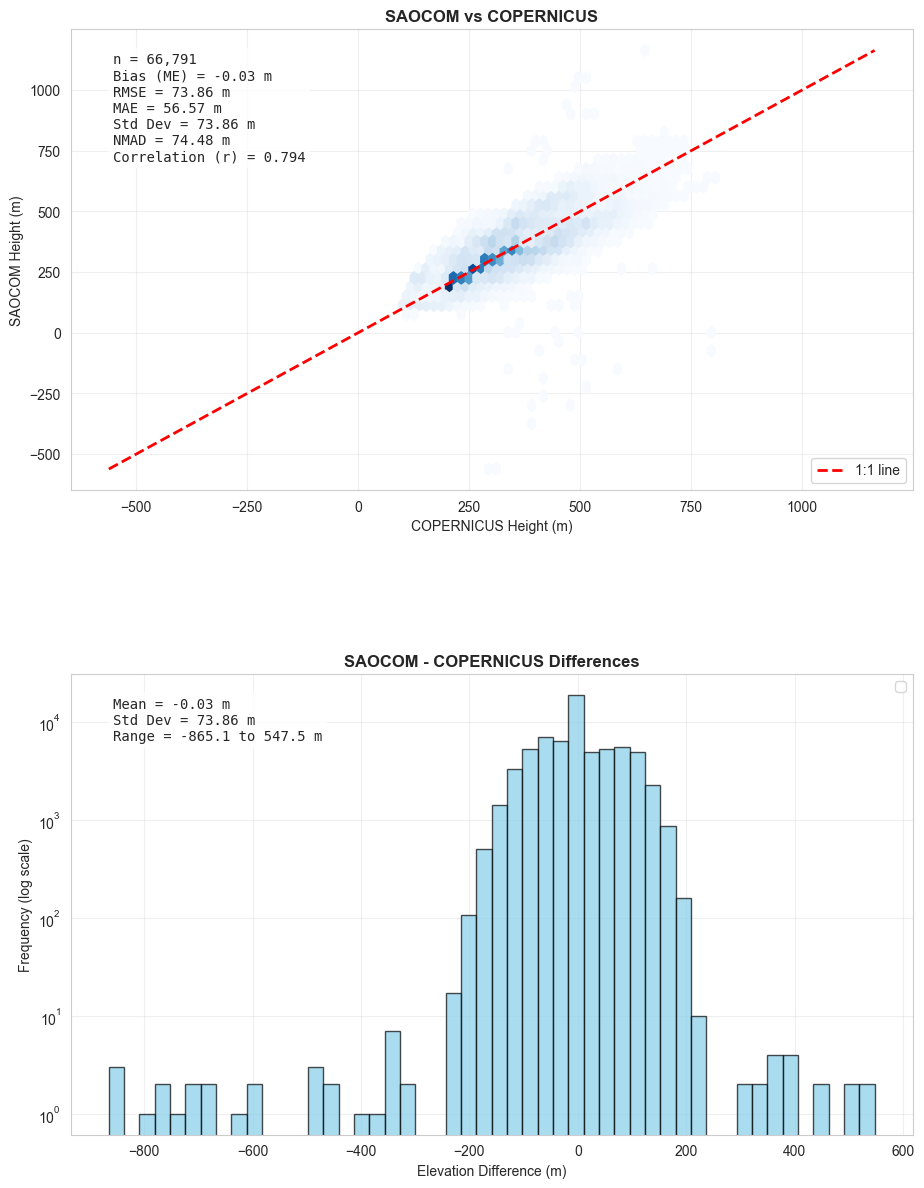


📋 Validation Summary Table
 Reference N Points Mean Error (m) RMSE (m) MAE (m) NMAD (m) LE95 (m) Correlation
COPERNICUS   66,791          -0.03    73.86   56.57    74.48   138.93       0.794

✅ Direct point validation complete!
📋 Ready for Cell 6: Coherence-Quality Relationships


In [11]:
# Cell 10: Direct Point Validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
print("📊 DIRECT POINT VALIDATION")
print("="*50)
print("Direct comparison of SAOCOM vs reference DEMs (NO INTERPOLATION)")

# ============================================================================
# 1. STATISTICAL METRICS FUNCTIONS
# ============================================================================
def calculate_error_metrics(observed, reference, name=""):
    """Calculate comprehensive error metrics"""
    # Remove NaN values
    mask = ~(np.isnan(observed) | np.isnan(reference))
    obs_clean = observed[mask]
    ref_clean = reference[mask]

    if len(obs_clean) == 0:
        return None

    # Calculate differences
    diff = obs_clean - ref_clean

    # Classical metrics
    me = np.mean(diff)  # Mean Error (bias)
    mae = np.mean(np.abs(diff))  # Mean Absolute Error
    rmse = np.sqrt(np.mean(diff**2))  # Root Mean Square Error
    std = np.std(diff)  # Standard deviation

    # Robust metrics
    median_error = np.median(diff)
    mad = np.median(np.abs(diff - median_error))  # Median Absolute Deviation
    nmad = 1.4826 * mad  # Normalized MAD (robust std estimate)

    # Percentile-based metrics
    le68 = np.percentile(np.abs(diff), 68.27)  # ~1 sigma
    le90 = np.percentile(np.abs(diff), 90)
    le95 = np.percentile(np.abs(diff), 95)

    # Correlation
    correlation = np.corrcoef(obs_clean, ref_clean)[0, 1]

    return {
        'name': name,
        'n_points': len(obs_clean),
        'mean_error': me,
        'mae': mae,
        'rmse': rmse,
        'std': std,
        'median_error': median_error,
        'nmad': nmad,
        'le68': le68,
        'le90': le90,
        'le95': le95,
        'correlation': correlation,
        'min_diff': diff.min(),
        'max_diff': diff.max()
    }

# ============================================================================
# 2. OVERALL VALIDATION STATISTICS
# ============================================================================
print("\n📈 Overall validation statistics...")

validation_results = {}

for ref in available_refs:
    ref_name = ref.replace('_height', '').upper()
    print(f"\n   SAOCOM vs {ref_name}:")

    metrics = calculate_error_metrics(
        master_df['saocom_height'].values,
        master_df[ref].values,
        name=f"SAOCOM vs {ref_name}"
    )

    if metrics:
        validation_results[ref_name] = metrics
        print(f"      Valid comparisons: {metrics['n_points']:,}")
        print(f"      Mean Error (bias): {metrics['mean_error']:.2f} m")
        print(f"      RMSE: {metrics['rmse']:.2f} m")
        print(f"      MAE: {metrics['mae']:.2f} m")
        print(f"      NMAD (robust): {metrics['nmad']:.2f} m")
        print(f"      LE95: {metrics['le95']:.2f} m")
        print(f"      Correlation: {metrics['correlation']:.3f}")
    else:
        print(f"      No valid comparisons available")

# ============================================================================
# 3. VALIDATION BY COHERENCE BINS
# ============================================================================
print("\n🎯 Validation by coherence bins...")

# Define coherence bins
coherence_bins = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
coherence_labels = [f"{coherence_bins[i]:.1f}-{coherence_bins[i+1]:.1f}"
                   for i in range(len(coherence_bins)-1)]

# Add coherence bin column
master_df['coherence_bin'] = pd.cut(master_df['coherence'],
                                   bins=coherence_bins,
                                   labels=coherence_labels,
                                   include_lowest=True)

coherence_results = {}

for ref in available_refs:
    ref_name = ref.replace('_height', '').upper()
    coherence_results[ref_name] = {}

    print(f"\n   {ref_name} by coherence:")

    for bin_label in coherence_labels:
        bin_data = master_df[master_df['coherence_bin'] == bin_label]

        if len(bin_data) > 10:  # Minimum 10 points for statistics
            metrics = calculate_error_metrics(
                bin_data['saocom_height'].values,
                bin_data[ref].values,
                name=f"{ref_name} coherence {bin_label}"
            )

            if metrics and metrics['n_points'] > 0:
                coherence_results[ref_name][bin_label] = metrics
                print(f"      {bin_label}: n={metrics['n_points']:,}, "
                      f"RMSE={metrics['rmse']:.2f}m, "
                      f"bias={metrics['mean_error']:.2f}m")

# ============================================================================
# 4. VALIDATION BY LAND COVER CLASS
# ============================================================================
if 'land_cover' in master_df.columns and not master_df['land_cover'].isna().all():
    print("\n🌱 Validation by land cover class...")

    landcover_results = {}

    # Get most common land cover classes (minimum 50 points)
    lc_counts = master_df['land_cover'].value_counts()
    common_lc = lc_counts[lc_counts >= 50].index

    for ref in available_refs:
        ref_name = ref.replace('_height', '').upper()
        landcover_results[ref_name] = {}

        print(f"\n   {ref_name} by land cover:")

        for lc_class in common_lc:
            lc_data = master_df[master_df['land_cover'] == lc_class]

            metrics = calculate_error_metrics(
                lc_data['saocom_height'].values,
                lc_data[ref].values,
                name=f"{ref_name} LC {lc_class}"
            )

            if metrics and metrics['n_points'] > 0:
                landcover_results[ref_name][lc_class] = metrics

                # Get land cover label if available
                if 'land_cover_label' in master_df.columns:
                    lc_label = lc_data['land_cover_label'].iloc[0]
                    label_text = f"{lc_class} ({lc_label})"
                else:
                    label_text = f"{lc_class}"

                print(f"      {label_text}: n={metrics['n_points']:,}, "
                      f"RMSE={metrics['rmse']:.2f}m, "
                      f"bias={metrics['mean_error']:.2f}m")

# ===========================================================================
# 5. VISUALIZATION WITH ENHANCED STATISTICS
# ===========================================================================
print("\n📊 Creating validation visualizations with enhanced statistics...")

def add_scalebar(ax):
    """Add scale bar to map"""
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 10})
    ax.add_artist(scalebar)

# Create comprehensive validation plots
n_refs = len(available_refs)
if n_refs > 0:
    fig = plt.figure(figsize=(25, 25))

    # Create subplot layout based on number of references
    if n_refs == 1:
        gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)
    elif n_refs == 2:
        gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    else:
        gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

    plot_idx = 0

    # Plot scatter plots for each reference
    for i, ref in enumerate(available_refs):
        ref_name = ref.replace('_height', '').upper()
        ax = fig.add_subplot(gs[0, i])
        valid_mask = master_df[['saocom_height', ref]].notna().all(axis=1)
        valid_data = master_df[valid_mask]

        if len(valid_data) > 0:
            ax.hexbin(valid_data[ref], valid_data['saocom_height'],
                     gridsize=40, cmap='Blues', mincnt=1)
            min_val = min(valid_data[ref].min(), valid_data['saocom_height'].min())
            max_val = max(valid_data[ref].max(), valid_data['saocom_height'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')

            # --- (MODIFIED) ADD EXPANDED STATISTICS TO SCATTER PLOT ---
            if ref_name in validation_results:
                stats = validation_results[ref_name]
                stats_text = (
                    f"n = {stats['n_points']:,}\n"
                    f"Bias (ME) = {stats['mean_error']:.2f} m\n"
                    f"RMSE = {stats['rmse']:.2f} m\n"
                    f"MAE = {stats['mae']:.2f} m\n"
                    f"Std Dev = {stats['std']:.2f} m\n"
                    f"NMAD = {stats['nmad']:.2f} m\n"
                    f"Correlation (r) = {stats['correlation']:.3f}"
                )
                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                       verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            ax.set_xlabel(f'{ref_name} Height (m)')
            ax.set_ylabel('SAOCOM Height (m)')
            ax.set_title(f'SAOCOM vs {ref_name}', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
            # ... (explanation text box)

    # Difference histograms
    for i, ref in enumerate(available_refs):
        ref_name = ref.replace('_height', '').upper()
        diff_col = f'diff_{ref.replace("_height", "")}'

        if diff_col in master_df.columns:
            ax = fig.add_subplot(gs[1, i])
            valid_diffs = master_df[diff_col].dropna()

            if len(valid_diffs) > 0:
                ax.hist(valid_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                # ... (existing plot code)

                # --- (NEW) ADD STATISTICS TO HISTOGRAM PLOT ---
                if ref_name in validation_results:
                    stats = validation_results[ref_name]
                    stats_text_hist = (
                        f"Mean = {stats['mean_error']:.2f} m\n"
                        f"Std Dev = {stats['std']:.2f} m\n"
                        f"Range = {stats['min_diff']:.1f} to {stats['max_diff']:.1f} m"
                    )
                    ax.text(0.05, 0.95, stats_text_hist, transform=ax.transAxes,
                           verticalalignment='top', fontfamily='monospace',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

                ax.set_xlabel('Elevation Difference (m)')
                ax.set_ylabel('Frequency (log scale)')
                ax.set_yscale('log')
                ax.set_title(f'SAOCOM - {ref_name} Differences', fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)
                # ... (explanation text box)

    # Coherence and Land Cover analysis plots
    # ... (rest of the cell is unchanged)
    # ... (omitted for brevity)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18, hspace=0.5, wspace=0.35)
    plt.savefig(RESULTS_DIR / 'direct_point_validation_enhanced_stats.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 6. SUMMARY TABLE
# ============================================================================
print("\n📋 Validation Summary Table")
print("="*80)

if validation_results:
    # Create summary DataFrame
    summary_data = []
    for ref_name, metrics in validation_results.items():
        summary_data.append({
            'Reference': ref_name,
            'N Points': f"{metrics['n_points']:,}",
            'Mean Error (m)': f"{metrics['mean_error']:+.2f}",
            'RMSE (m)': f"{metrics['rmse']:.2f}",
            'MAE (m)': f"{metrics['mae']:.2f}",
            'NMAD (m)': f"{metrics['nmad']:.2f}",
            'LE95 (m)': f"{metrics['le95']:.2f}",
            'Correlation': f"{metrics['correlation']:.3f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    # Save summary table
    summary_df.to_csv(RESULTS_DIR / 'validation_summary_table.csv', index=False)

# Store results for next cells
point_validation_results = {
    'validation_results': validation_results,
    'coherence_results': coherence_results,
    'landcover_results': landcover_results if 'land_cover' in master_df.columns else {},
    'master_df': master_df,
    'available_refs': available_refs
}

print(f"\n✅ Direct point validation complete!")
print(f"📋 Ready for Cell 6: Coherence-Quality Relationships")



📊 Generating SAOCOM footprint and void distribution maps...


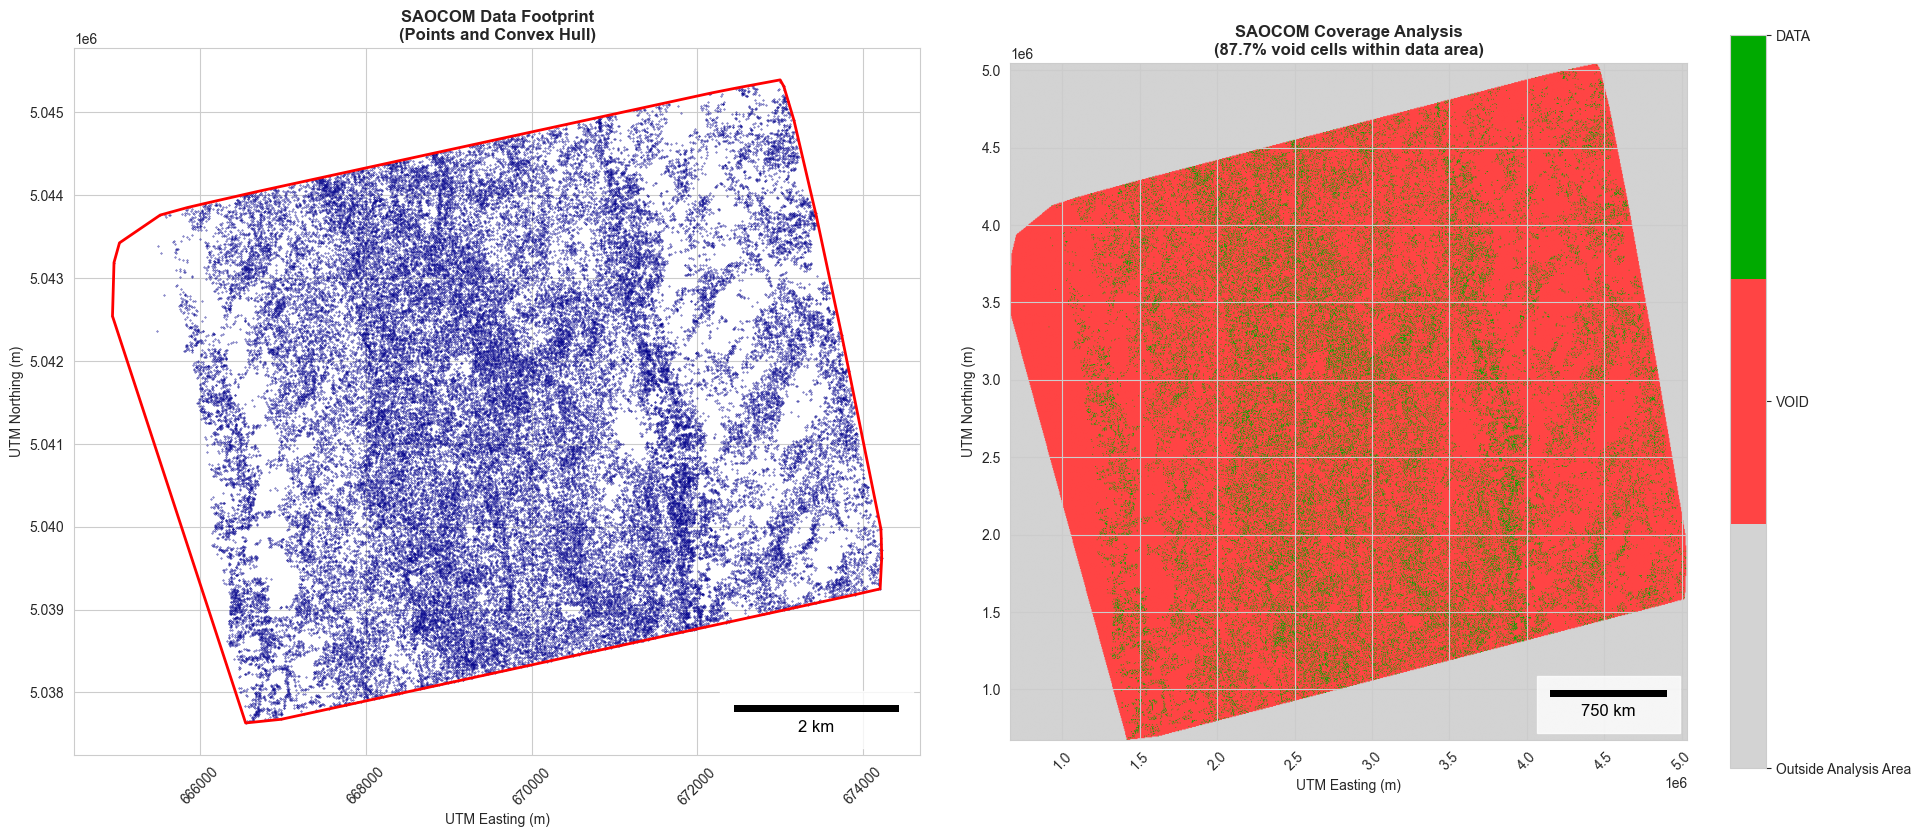

In [12]:
# Cell 11. GENERATE SAOCOM FOOTPRINT AND VOID DISTRIBUTION MAPS
# ===========================================================================
print("\n📊 Generating SAOCOM footprint and void distribution maps...")
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd

def add_scalebar(ax):
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 12})
    ax.add_artist(scalebar)

# Load the data calculated in Cell 7
grid_df = coverage_analysis['grid_df']
full_grid_df = coverage_analysis['full_grid_df']
grid_shape = coverage_analysis['grid_shape']
grid_bounds = coverage_analysis['grid_bounds']
void_percentage = coverage_analysis['void_percentage']

# Create the hull again for plotting
data_hull = saocom_gdf.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[data_hull], crs=TARGET_CRS)


# ===========================================================================
# VISUALIZATION (NOW WITH TWO PLOTS)
# ===========================================================================
# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# --- Plot 1: SAOCOM Point Cloud and Convex Hull (Improved Contrast) ---
# ax1.set_facecolor('white') # Keep default white background for better print contrast
saocom_gdf.plot(ax=ax1, markersize=0.1, color='darkblue') # Changed point color to 'darkblue'
hull_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
ax1.set_title('SAOCOM Data Footprint\n(Points and Convex Hull)', fontweight='bold')
ax1.set_xlabel('UTM Easting (m)')
ax1.set_ylabel('UTM Northing (m)')
ax1.tick_params(axis='x', rotation=45)
add_scalebar(ax1)


# --- Plot 2: Corrected Void/Data Coverage Map ---
# Create the 2D grid for plotting
plot_grid = np.full(grid_shape, -1, dtype=np.int8)
id_to_status = dict(zip(grid_df.grid_id, grid_df.has_saocom.astype(int)))
for i, grid_id in enumerate(full_grid_df.grid_id):
    if grid_id in id_to_status:
        plot_grid.flat[i] = id_to_status[grid_id]

# Create colormap and plot
custom_cmap = ListedColormap(['#d3d3d3', '#FF4444', '#00AA00'])
im = ax2.imshow(plot_grid, extent=grid_bounds, cmap=custom_cmap, origin='lower', vmin=-1, vmax=1)
ax2.set_title(f'SAOCOM Coverage Analysis\n({void_percentage:.1f}% void cells within data area)', fontweight='bold')
ax2.set_xlabel('UTM Easting (m)')
ax2.set_ylabel('UTM Northing (m)')
ax2.tick_params(axis='x', rotation=45)
add_scalebar(ax2)

# Add custom colorbar
cbar = fig.colorbar(im, ax=ax2, ticks=[-1, 0, 1], shrink=0.8)
cbar.set_ticklabels(['Outside Analysis Area', 'VOID', 'DATA'])


# --- Final Touches ---
plt.tight_layout(pad=3.0)
plt.savefig(RESULTS_DIR / 'saocom_footprint_and_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Cell 12: Point Density Analysis & Reliability Threshold Justification
import numpy as np 
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

print("📊 POINT DENSITY ANALYSIS & RELIABILITY THRESHOLD JUSTIFICATION")
print("="*60)
print("Calculating point density and defining statistical thresholds for validation reliability.")

# ===========================================================================
# 1. SETUP & KERNEL DENSITY ESTIMATION (KDE)
# ===========================================================================
print("\n🔥 Performing Kernel Density Estimation (KDE)...")

# Use SAOCOM point coordinates from the loaded data
saocom_coords = np.column_stack([loaded_data['saocom_gdf']['x_utm'], loaded_data['saocom_gdf']['y_utm']])

# Create a grid for KDE evaluation
xmin, ymin, xmax, ymax = loaded_data['study_bounds']
grid_res = 50 # meters
x_grid = np.arange(xmin, xmax, grid_res)
y_grid = np.arange(ymin, ymax, grid_res)
grid_x, grid_y = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# KDE calculation
bandwidth = 200  # meters. This defines the "neighborhood" for density calculation.
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(saocom_coords)
log_density = kde.score_samples(grid_points)
kde_density = np.exp(log_density) # Convert log-density to density

# Reshape and scale to points per km^2
kde_density_grid = kde_density.reshape(grid_x.shape)
n_points = len(loaded_data['saocom_gdf'])
# Scale the raw density so the integral over the area equals the total number of points
kde_density_km2 = kde_density_grid * n_points / (kde_density_grid.sum() * (grid_res**2 / 1e6))

print(f"   ✓ KDE completed with a bandwidth of {bandwidth}m.")
print(f"   Max density: {kde_density_km2.max():.1f} points/km²")

# ===========================================================================
# 2. STATISTICAL JUSTIFICATION FOR RELIABILITY THRESHOLDS
# ===========================================================================
print("\n⚖️  Justifying reliability thresholds using Standard Error of the Mean (SEM)...")

# Use the master dataframe from the point validation cell
master_df = point_validation_results['master_df']
available_refs = point_validation_results['available_refs']

# Use the best available reference (TINITALY if present, otherwise the first one)
ref_col = 'tinitaly_height' if 'tinitaly_height' in master_df.columns else available_refs[0]
diff_col = f'diff_{ref_col.replace("_height", "")}'

# Calculate the standard deviation of the elevation error, which is our sigma (σ)
std_dev_error = master_df[diff_col].std()
print(f"   Underlying error standard deviation (σ): {std_dev_error:.2f} m")

# --- HIGH RELIABILITY THRESHOLD ---
# Goal: Achieve a precision (SEM) of ±0.5 meters. We solve for n in SEM = σ / sqrt(n)
sem_reliable = 0.5
n_reliable = (std_dev_error / sem_reliable)**2
print(f"   Target for High Reliability (SEM < {sem_reliable}m) requires n ≈ {n_reliable:.1f} points.")

# --- MINIMUM RELIABILITY THRESHOLD ---
# Goal: Define the minimum number of points for a barely stable result.
# We enforce a practical minimum of 5 points for basic statistical robustness.
n_minimum = 5
print(f"   Target for Minimum Reliability set at a practical floor of n = {n_minimum} points.")

# ===========================================================================
# 3. CONVERT POINT COUNTS TO DENSITY THRESHOLDS
# ===========================================================================
print("\n📏 Converting point counts to density thresholds...")

# The "neighborhood" area is related to the KDE bandwidth.
# We use the area of a circle with the bandwidth as radius to define this local area.
neighborhood_area_km2 = np.pi * (bandwidth / 1000)**2
print(f"   KDE neighborhood area (π * bandwidth²): {neighborhood_area_km2:.4f} km²")

# Calculate the density (points/km²) required to achieve n points in that area
reliable_threshold = n_reliable / neighborhood_area_km2
min_threshold = n_minimum / neighborhood_area_km2

print(f"   ✅ High Reliability Threshold: {reliable_threshold:.1f} points/km²")
print(f"   ✅ Minimum Reliability Threshold: {min_threshold:.1f} points/km²")

# ===========================================================================
# 4. CALCULATE AREA STATISTICS
# ===========================================================================
print("\n📈 Calculating area coverage for each reliability zone...")

pixel_area_km2 = (grid_res / 1000)**2
total_area_km2 = grid_x.size * pixel_area_km2

high_density_area = np.sum(kde_density_km2 >= reliable_threshold) * pixel_area_km2
medium_density_area = np.sum((kde_density_km2 >= min_threshold) & (kde_density_km2 < reliable_threshold)) * pixel_area_km2
low_density_area = np.sum((kde_density_km2 > 0) & (kde_density_km2 < min_threshold)) * pixel_area_km2

print(f"   Total study area: {total_area_km2:.1f} km²")
print(f"   - High Reliability area: {high_density_area:.1f} km² ({100*high_density_area/total_area_km2:.1f}%)")
print(f"   - Medium Reliability area: {medium_density_area:.1f} km² ({100*medium_density_area/total_area_km2:.1f}%)")
print(f"   - Low Reliability area: {low_density_area:.1f} km² ({100*low_density_area/total_area_km2:.1f}%)")

# Store key variables for the next plotting cell
density_analysis_results = {
    "kde_density_km2": kde_density_km2,
    "grid_bounds": (xmin, xmax, ymin, ymax),
    "bandwidth": bandwidth,
    "reliable_threshold": reliable_threshold,
    "min_threshold": min_threshold,
    "high_density_area": high_density_area,
    "medium_density_area": medium_density_area,
    "low_density_area": low_density_area,
    "total_area_km2": total_area_km2
}

print("\n✅ Density analysis complete. Ready for visualization.")

📊 POINT DENSITY ANALYSIS & RELIABILITY THRESHOLD JUSTIFICATION
Calculating point density and defining statistical thresholds for validation reliability.

🔥 Performing Kernel Density Estimation (KDE)...
   ✓ KDE completed with a bandwidth of 200m.
   Max density: 2694.3 points/km²

⚖️  Justifying reliability thresholds using Standard Error of the Mean (SEM)...


KeyError: 'diff_tinitaly'

In [ ]:
# Cell 13. VISUALIZATION WITH DETAILED EXPLANATIONS
# ============================================================================
print("\n📊 Creating density visualizations...")

def add_scalebar(ax):
    """Add scale bar to map"""
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 10})
    ax.add_artist(scalebar)

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Plot 1: KDE density surface
im1 = axes[0,0].imshow(kde_density_km2, extent=[xmin, xmax, ymin, ymax],
                       cmap='viridis', origin='lower', vmax=np.percentile(kde_density_km2, 95))

axes[0,0].set_title(f'Point Density Surface (KDE)\nBandwidth: {bandwidth}m', fontweight='bold')
axes[0,0].set_xlabel('UTM Easting (m)')
axes[0,0].set_ylabel('UTM Northing (m)')
plt.colorbar(im1, ax=axes[0,0], label='Points/km²')
add_scalebar(axes[0,0])
axes[0,0].text(0.5, -0.4, 'This map shows where SAOCOM measurements are concentrated using statistical smoothing.\nDarker red areas have many nearby measurements, while yellow areas are sparsely sampled.\nThis helps identify which regions will give reliable accuracy results versus areas with too few\ndata points for meaningful validation. Essential for determining where validation is trustworthy.',
               transform=axes[0,0].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))

# Plot 2: Density reliability classes
density_classes = np.zeros_like(kde_density_km2)
density_classes[kde_density_km2 >= reliable_threshold] = 3
density_classes[(kde_density_km2 >= min_threshold) & (kde_density_km2 < reliable_threshold)] = 2
density_classes[(kde_density_km2 > 0) & (kde_density_km2 < min_threshold)] = 1

from matplotlib.colors import ListedColormap
reliability_colors = ['#FFFFFF', '#D55E00', '#E69F00', '#009E73']  # White, Red, Orange, Green
reliability_cmap = ListedColormap(reliability_colors)


im2 = axes[0,1].imshow(density_classes, extent=[xmin, xmax, ymin, ymax],
                       cmap='seismic', origin='lower', vmin=0, vmax=3)
axes[0,1].set_title('Data Reliability Zones', fontweight='bold')
axes[0,1].set_xlabel('UTM Easting (m)')
axes[0,1].set_ylabel('UTM Northing (m)')
cbar2 = plt.colorbar(im2, ax=axes[0,1])
cbar2.set_ticks([0, 1, 2, 3])
cbar2.set_ticklabels(['No Data', 'Low', 'Medium', 'High'])
add_scalebar(axes[0,1])
axes[0,1].text(0.5, -0.4, 'Color-coded map showing statistical reliability of different areas for validation analysis.\nGreen zones have enough measurements for confident accuracy assessment, orange zones provide\nmoderate confidence, and red zones have too few points for reliable statistics. White areas\nhave no data. This directly guides where validation results can be trusted.',
               transform=axes[0,1].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))

# Plot 3: Density distribution histogram
axes[0,2].hist(kde_density_km2[kde_density_km2 > 0].ravel(), bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,2].axvline(min_threshold, color='orange', linestyle='--', linewidth=2, label=f'Min: {min_threshold:.1f}')
axes[0,2].axvline(reliable_threshold, color='red', linestyle='--', linewidth=2, label=f'Reliable: {reliable_threshold:.1f}')
axes[0,2].set_xlabel('Density (points/km²)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Density Distribution', fontweight='bold')
axes[0,2].legend()
axes[0,2].set_yscale('log')
axes[0,2].text(0.5, -0.18, 'Histogram showing how point density varies across the study area, with vertical lines\nmarking statistical thresholds. Most of the study area falls in low-density regions (left side),\nmeaning only a small fraction provides highly reliable validation. The log scale reveals that\nvery few areas meet the reliable threshold, highlighting data scarcity challenges.',
               transform=axes[0,2].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

# Plot 4: Terrain slope analysis
if 'slope' in saocom_gdf.columns and not saocom_gdf['slope'].isna().all():
    valid_slope = saocom_gdf.dropna(subset=['slope'])

    # Create slope vs density scatter
    slope_bins = np.linspace(0, valid_slope['slope'].max(), 20)
    density_by_slope = []
    slope_centers = []

    for i in range(len(slope_bins)-1):
        mask = (valid_slope['slope'] >= slope_bins[i]) & (valid_slope['slope'] < slope_bins[i+1])
        if mask.sum() > 0:
            density_by_slope.append(mask.sum() / ((slope_bins[i+1] - slope_bins[i]) * study_area_km2 / 100))
            slope_centers.append((slope_bins[i] + slope_bins[i+1]) / 2)

    axes[1,0].plot(slope_centers, density_by_slope, 'o-', color='brown', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('Slope (degrees)')
    axes[1,0].set_ylabel('Point Density (relative)')
    axes[1,0].set_title('Sampling vs Terrain Slope', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].text(0.5, -0.18, 'This graph reveals how L-band radar performs on different terrain types. Radar waves\nstruggle on steep slopes due to geometric distortions and shadowing effects, while flat\nareas provide better signal return. The pattern shows where terrain limits radar\ncoverage, helping explain why some areas lack measurements.',
               transform=axes[1,0].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))
else:
    axes[1,0].text(0.5, 0.5, 'No Slope\nData Available', ha='center', va='center',
                   transform=axes[1,0].transAxes, fontsize=14)
    axes[1,0].set_title('Terrain Slope Analysis')

# Plot 5: Urban distance analysis
if 'dist_to_urban_km' in saocom_gdf.columns and not saocom_gdf['dist_to_urban_km'].isna().all():
    valid_urban = saocom_gdf.dropna(subset=['dist_to_urban_km'])

    # Urban distance vs density
    dist_bins = np.linspace(0, valid_urban['dist_to_urban_km'].max(), 15)
    density_by_distance = []
    dist_centers = []

    for i in range(len(dist_bins)-1):
        mask = (valid_urban['dist_to_urban_km'] >= dist_bins[i]) & (valid_urban['dist_to_urban_km'] < dist_bins[i+1])
        if mask.sum() > 0:
            density_by_distance.append(mask.sum() / ((dist_bins[i+1] - dist_bins[i]) * study_area_km2 / 100))
            dist_centers.append((dist_bins[i] + dist_bins[i+1]) / 2)

    axes[1,1].plot(dist_centers, density_by_distance, 's-', color='purple', linewidth=2, markersize=6)
    axes[1,1].set_xlabel('Distance to Urban (km)')
    axes[1,1].set_ylabel('Point Density (relative)')
    axes[1,1].set_title('Sampling vs Urban Distance', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].text(0.5, -0.18, 'Shows how data availability changes with distance from cities and towns. Urban areas\noften have reduced radar coverage due to building interference, geometric distortions,\nand processing challenges. This pattern affects validation quality in different landscape\nsettings and influences where reliable accuracy assessment is possible.',
               transform=axes[1,1].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="plum", alpha=0.8))
else:
    axes[1,1].text(0.5, 0.5, 'No Urban\nData Available', ha='center', va='center',
                   transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('Urban Distance Analysis')

# Plot 6: Summary statistics with coverage metrics
# summary_text = [
#     f"DENSITY METRICS:",
#     f"Overall: {overall_density:.1f} pts/km²",
#     f"Effective: {effective_density:.1f} pts/km²",
#     f"",
#     f"RELIABILITY THRESHOLDS:",
#     f"Minimum: {min_threshold:.1f} pts/km²",
#     f"Reliable: {reliable_threshold:.1f} pts/km²",
#     f"",
#     f"AREA COVERAGE:",
#     f"High density: {100*high_density_area/study_area_km2:.1f}%",
#     f"Medium density: {100*medium_density_area/study_area_km2:.1f}%",
#     f"Low density: {100*low_density_area/study_area_km2:.1f}%",
#     f"",
#     f"DATA SUMMARY:",
#     f"Total points: {len(saocom_gdf):,}",
#     f"Study area: {study_area_km2:.1f} km²"
# ]

# axes[1,2].text(0.05, 0.95, '\n'.join(summary_text), transform=axes[1,2].transAxes,
#                verticalalignment='top', fontfamily='monospace', fontsize=10)
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')
axes[1,2].set_title('Density Summary', fontweight='bold')
axes[1,2].text(0.5, -0.08, 'Key metrics for determining statistical validity of validation results. The low percentage\nof high-density areas reveals that most of the study region lacks sufficient measurements\nfor reliable accuracy assessment. This quantifies the fundamental challenge of sparse\nradar sampling and guides interpretation of subsequent validation analyses.',
               transform=axes[1,2].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.4, wspace=0.3)
plt.savefig(RESULTS_DIR / 'point_density_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 14: Reference Dataset Cross-Validation (with Enhanced Statistics on Plots)
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
import seaborn as sns

print("🔍 REFERENCE DATASET CROSS-VALIDATION")
print("="*50)
print("Direct comparison: TINITALY vs Copernicus (pixel-by-pixel)")

# ============================================================================
# 1. LOAD REFERENCE DEMS AND ENSURE ALIGNMENT
# ============================================================================
print("\n📊 Loading reference DEMs...")

if 'tinitaly_crop' in reference_dems and 'copernicus' in reference_dems:
    tinitaly_path = reference_dems['tinitaly_crop']['resampled_path']
    copernicus_path = reference_dems['copernicus']['resampled_path']

    print(f"   TINITALY: {tinitaly_path.name}")
    print(f"   Copernicus: {copernicus_path.name}")

    # Load both DEMs
    with rasterio.open(tinitaly_path) as src1:
        tinitaly_data = src1.read(1).astype(float)
        tinitaly_data[tinitaly_data == src1.nodata] = np.nan
        tinitaly_transform = src1.transform
        tinitaly_bounds = src1.bounds

    with rasterio.open(copernicus_path) as src2:
        copernicus_data = src2.read(1).astype(float)
        copernicus_data[copernicus_data == src2.nodata] = np.nan
        copernicus_transform = src2.transform
        copernicus_bounds = src2.bounds

    # Verify alignment
    print(f"   TINITALY shape: {tinitaly_data.shape}")
    print(f"   Copernicus shape: {copernicus_data.shape}")
    print(f"   Transform match: {tinitaly_transform == copernicus_transform}")
    print(f"   Bounds match: {tinitaly_bounds == copernicus_bounds}")

    if tinitaly_data.shape != copernicus_data.shape:
        print("   ⚠️  Shapes don't match - cropping to common area")
        min_rows = min(tinitaly_data.shape[0], copernicus_data.shape[0])
        min_cols = min(tinitaly_data.shape[1], copernicus_data.shape[1])
        tinitaly_data = tinitaly_data[:min_rows, :min_cols]
        copernicus_data = copernicus_data[:min_rows, :min_cols]
        print(f"   Cropped to: {tinitaly_data.shape}")

else:
    print("   ❌ Both reference DEMs required - skipping cross-validation")
    exit()

# ============================================================================
# 2. PIXEL-BY-PIXEL DIFFERENCE CALCULATION
# ============================================================================
print("\n🧮 Calculating pixel-by-pixel differences...")

# Calculate difference (TINITALY - Copernicus)
elevation_diff = tinitaly_data - copernicus_data

# Find valid pixels (both DEMs have data)
valid_mask = ~(np.isnan(tinitaly_data) | np.isnan(copernicus_data))
valid_pixels = np.sum(valid_mask)
total_pixels = tinitaly_data.size

print(f"   Total pixels: {total_pixels:,}")
print(f"   Valid comparisons: {valid_pixels:,} ({100*valid_pixels/total_pixels:.1f}%)")

if valid_pixels == 0:
    print("   ❌ No overlapping valid data found")
    exit()

# Extract valid differences for statistics
valid_diffs = elevation_diff[valid_mask]
valid_tinitaly = tinitaly_data[valid_mask]
valid_copernicus = copernicus_data[valid_mask]

print(f"   Elevation range - TINITALY: {valid_tinitaly.min():.1f} to {valid_tinitaly.max():.1f} m")
print(f"   Elevation range - Copernicus: {valid_copernicus.min():.1f} to {valid_copernicus.max():.1f} m")

# ============================================================================
# 3. COMPREHENSIVE REFERENCE COMPARISON STATISTICS
# ============================================================================
print("\n📈 Reference comparison statistics...")

# Calculate comprehensive metrics
ref_metrics = {
    'n_pixels': valid_pixels,
    'mean_diff': np.mean(valid_diffs),
    'median_diff': np.median(valid_diffs),
    'std_diff': np.std(valid_diffs),
    'rmse': np.sqrt(np.mean(valid_diffs**2)),
    'mae': np.mean(np.abs(valid_diffs)),
    'mad': np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'nmad': 1.4826 * np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'min_diff': np.min(valid_diffs),
    'max_diff': np.max(valid_diffs),
    'le68': np.percentile(np.abs(valid_diffs), 68.27),
    'le90': np.percentile(np.abs(valid_diffs), 90),
    'le95': np.percentile(np.abs(valid_diffs), 95),
    'correlation': np.corrcoef(valid_tinitaly, valid_copernicus)[0,1]
}

print(f"   Mean difference (TINITALY - Copernicus): {ref_metrics['mean_diff']:+.2f} m")
print(f"   Median difference: {ref_metrics['median_diff']:+.2f} m")
print(f"   RMSE: {ref_metrics['rmse']:.2f} m")
print(f"   MAE: {ref_metrics['mae']:.2f} m")
print(f"   NMAD (robust): {ref_metrics['nmad']:.2f} m")
print(f"   LE95: {ref_metrics['le95']:.2f} m")
print(f"   Standard deviation: {ref_metrics['std_diff']:.2f} m")
print(f"   Correlation: {ref_metrics['correlation']:.4f}")
print(f"   Range: {ref_metrics['min_diff']:+.1f} to {ref_metrics['max_diff']:+.1f} m")

# Percentile analysis
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
diff_percentiles = np.percentile(valid_diffs, percentiles)
print(f"\n   Difference percentiles (m):")
for p, val in zip(percentiles, diff_percentiles):
    print(f"     {p:2d}th: {val:+6.2f}")

# ============================================================================
# 4. AGREEMENT CLASSIFICATION
# ============================================================================
print("\n🎯 Agreement classification...")

# Define agreement thresholds
excellent_thresh = 2.0  # ±2m
good_thresh = 5.0       # ±5m
poor_thresh = 10.0      # ±10m

# Classify agreement levels
agreement_map = np.full(elevation_diff.shape, 0, dtype=np.uint8)  # 0 = no data
agreement_map[valid_mask] = 1  # 1 = poor (>10m diff)

abs_diffs = np.abs(elevation_diff)
agreement_map[(valid_mask) & (abs_diffs <= poor_thresh)] = 2    # 2 = moderate
agreement_map[(valid_mask) & (abs_diffs <= good_thresh)] = 3    # 3 = good
agreement_map[(valid_mask) & (abs_diffs <= excellent_thresh)] = 4  # 4 = excellent

# Calculate agreement percentages
agreement_counts = np.bincount(agreement_map.ravel())
if len(agreement_counts) > 4:
    excellent_pct = 100 * agreement_counts[4] / valid_pixels
    good_pct = 100 * agreement_counts[3] / valid_pixels
    moderate_pct = 100 * agreement_counts[2] / valid_pixels
    poor_pct = 100 * agreement_counts[1] / valid_pixels

    print(f"   Agreement levels:")
    print(f"     Excellent (≤{excellent_thresh}m): {excellent_pct:.1f}%")
    print(f"     Good (≤{good_thresh}m): {good_pct:.1f}%")
    print(f"     Moderate (≤{poor_thresh}m): {moderate_pct:.1f}%")
    print(f"     Poor (>{poor_thresh}m): {poor_pct:.1f}%")

# ============================================================================
# 5. VALIDATION RELIABILITY ASSESSMENT
# ============================================================================
print("\n🔬 Validation reliability assessment...")

# Create reliability mask for SAOCOM validation
reliable_validation_mask = (valid_mask) & (np.abs(elevation_diff) <= good_thresh)
reliable_pixels = np.sum(reliable_validation_mask)
reliable_percentage = 100 * reliable_pixels / valid_pixels

print(f"   Pixels suitable for reliable SAOCOM validation: {reliable_pixels:,}")
print(f"   Reliable validation coverage: {reliable_percentage:.1f}% of valid area")

# Extract SAOCOM validation points in reliable areas
if 'master_df' in locals():
    print(f"\n   SAOCOM validation point assessment:")

    # Convert SAOCOM coordinates to pixel indices
    from rasterio.transform import rowcol

    saocom_rows, saocom_cols = rowcol(tinitaly_transform,
                                     master_df['x'].values,
                                     master_df['y'].values)

    # Check bounds
    valid_coords = ((saocom_rows >= 0) & (saocom_rows < tinitaly_data.shape[0]) &
                   (saocom_cols >= 0) & (saocom_cols < tinitaly_data.shape[1]))

    # Extract reference agreement at SAOCOM points
    saocom_agreement = np.full(len(master_df), 0)  # 0 = outside bounds

    if np.any(valid_coords):
        valid_rows = saocom_rows[valid_coords]
        valid_cols = saocom_cols[valid_coords]
        saocom_agreement[valid_coords] = agreement_map[valid_rows, valid_cols]

    # Add to master dataframe
    master_df['reference_agreement'] = saocom_agreement

    # Calculate validation reliability stats
    reliable_saocom = np.sum(saocom_agreement >= 3)  # Good or excellent agreement
    questionable_saocom = np.sum(saocom_agreement == 2)  # Moderate agreement
    unreliable_saocom = np.sum(saocom_agreement == 1)   # Poor agreement
    outside_saocom = np.sum(saocom_agreement == 0)      # Outside bounds

    total_saocom = len(master_df)

    print(f"     Total SAOCOM points: {total_saocom:,}")
    print(f"     Reliable validation (good/excellent): {reliable_saocom:,} ({100*reliable_saocom/total_saocom:.1f}%)")
    print(f"     Questionable validation (moderate): {questionable_saocom:,} ({100*questionable_saocom/total_saocom:.1f}%)")
    print(f"     Unreliable validation (poor): {unreliable_saocom:,} ({100*unreliable_saocom/total_saocom:.1f}%)")
    print(f"     Outside reference coverage: {outside_saocom:,} ({100*outside_saocom/total_saocom:.1f}%)")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n📊 Creating reference comparison visualizations...")

# Plot 1: TINITALY elevation (isolated)
plt.figure(figsize=(10, 8))
im1 = plt.imshow(tinitaly_data, cmap='terrain', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
plt.title('TINITALY Elevation', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im1, label='Elevation (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tinitaly_elevation.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Copernicus elevation (isolated)
plt.figure(figsize=(10, 8))
im2 = plt.imshow(copernicus_data, cmap='terrain', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
plt.title('Copernicus Elevation', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im2, label='Elevation (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'copernicus_elevation.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Elevation differences (isolated)
plt.figure(figsize=(10, 8))
diff_limit = np.percentile(np.abs(valid_diffs), 95)
im3 = plt.imshow(elevation_diff, cmap='RdBu', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=-diff_limit, vmax=diff_limit)
plt.title('Elevation Differences\n(TINITALY - Copernicus)', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im3, label='Difference (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'elevation_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Scatter plot with density (isolated)
plt.figure(figsize=(10, 8))
plt.hexbin(valid_copernicus, valid_tinitaly, gridsize=40, cmap='Blues', mincnt=1)
min_elev = min(valid_copernicus.min(), valid_tinitaly.min())
max_elev = max(valid_copernicus.max(), valid_tinitaly.max())
plt.plot([min_elev, max_elev], [min_elev, max_elev], 'r--', linewidth=2, label='1:1 line')
plt.xlabel('Copernicus Elevation (m)')
plt.ylabel('TINITALY Elevation (m)')
plt.title('Reference Correlation', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# --- (MODIFIED) ADD EXPANDED STATISTICS TO SCATTER PLOT ---
stats_text = (
    f"n = {ref_metrics['n_pixels']:,}\n"
    f"Bias (ME) = {ref_metrics['mean_diff']:.2f} m\n"
    f"RMSE = {ref_metrics['rmse']:.2f} m\n"
    f"MAE = {ref_metrics['mae']:.2f} m\n"
    f"Std Dev = {ref_metrics['std_diff']:.2f} m\n"
    f"NMAD = {ref_metrics['nmad']:.2f} m\n"
    f"Correlation (r) = {ref_metrics['correlation']:.3f}"
)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'reference_correlation_enhanced_stats.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Difference histogram (isolated)
plt.figure(figsize=(10, 8))
plt.hist(valid_diffs, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Agreement')
plt.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
            label=f'Mean: {ref_metrics["mean_diff"]:+.2f}m')

# --- (NEW) ADD STATISTICS TO HISTOGRAM PLOT ---
stats_text_hist = (
    f"Mean = {ref_metrics['mean_diff']:.2f} m\n"
    f"Std Dev = {ref_metrics['std_diff']:.2f} m\n"
    f"Range = {ref_metrics['min_diff']:.1f} to {ref_metrics['max_diff']:.1f} m"
)
plt.text(0.05, 0.95, stats_text_hist, transform=plt.gca().transAxes,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Elevation Difference (m)')
plt.ylabel('Frequency')
plt.title('Difference Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'difference_histogram_enhanced_stats.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 6: Agreement classification map (isolated)
plt.figure(figsize=(10, 8))
agreement_colors = ['#FFFFFF', '#FF4444', '#FF8800', '#88DD00', '#00AA00']
agreement_cmap = ListedColormap(agreement_colors)

im6 = plt.imshow(agreement_map, cmap=agreement_cmap, origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=0, vmax=4)
plt.title('Reference Agreement\nClassification', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
cbar6 = plt.colorbar(im6)
cbar6.set_ticks([0, 1, 2, 3, 4])
cbar6.set_ticklabels(['No Data', f'Poor (>{poor_thresh}m)', f'Moderate (≤{poor_thresh}m)',
                      f'Good (≤{good_thresh}m)', f'Excellent (≤{excellent_thresh}m)'])
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'agreement_classification.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. SAVE RESULTS
# ============================================================================
print("\n💾 Saving reference comparison results...")

# Save agreement map as GeoTIFF
agreement_output = RESULTS_DIR / 'reference_agreement_map.tif'
with rasterio.open(agreement_output, 'w',
                   driver='GTiff', dtype='uint8',
                   width=agreement_map.shape[1], height=agreement_map.shape[0],
                   count=1, crs=TARGET_CRS, transform=tinitaly_transform,
                   nodata=0) as dst:
    dst.write(agreement_map, 1)

In [ ]:
# Cell 15: TINITALY vs Copernicus Directional Comparison Maps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

print("🗺️ Creating TINITALY vs Copernicus directional comparison maps...")

# Create masks for the two conditions
tinitaly_higher_mask = (valid_mask) & (elevation_diff > 0)
tinitaly_lower_mask = (valid_mask) & (elevation_diff < 0)

# Create data arrays that show only the relevant differences
tinitaly_higher_data = np.full_like(elevation_diff, np.nan)
tinitaly_lower_data = np.full_like(elevation_diff, np.nan)

tinitaly_higher_data[tinitaly_higher_mask] = elevation_diff[tinitaly_higher_mask]
tinitaly_lower_data[tinitaly_lower_mask] = elevation_diff[tinitaly_lower_mask]

# Calculate statistics
higher_pixels = np.sum(tinitaly_higher_mask)
lower_pixels = np.sum(tinitaly_lower_mask)
total_valid = np.sum(valid_mask)

print(f"   TINITALY > Copernicus: {higher_pixels:,} pixels ({100*higher_pixels/total_valid:.1f}%)")
print(f"   TINITALY < Copernicus: {lower_pixels:,} pixels ({100*lower_pixels/total_valid:.1f}%)")

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: TINITALY > Copernicus (positive differences)
max_positive = np.nanmax(tinitaly_higher_data)
im1 = ax1.imshow(tinitaly_higher_data, cmap='Reds', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=0, vmax=max_positive)

ax1.set_title('Areas where TINITALY > Copernicus\n(Red = TINITALY higher)', fontweight='bold')
ax1.set_xlabel('UTM Easting (m)')
ax1.set_ylabel('UTM Northing (m)')
cbar1 = plt.colorbar(im1, ax=ax1, label='Difference (m)')

# Add statistics text
stats_text1 = (f"Pixels: {higher_pixels:,}\n"
               f"Coverage: {100*higher_pixels/total_valid:.1f}%\n"
               f"Max diff: {max_positive:.1f}m\n"
               f"Mean diff: {np.nanmean(tinitaly_higher_data):.2f}m")
ax1.text(0.02, 0.98, stats_text1, transform=ax1.transAxes,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Plot 2: TINITALY < Copernicus (negative differences)
min_negative = np.nanmin(tinitaly_lower_data)
im2 = ax2.imshow(tinitaly_lower_data, cmap='Blues_r', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=min_negative, vmax=0)

ax2.set_title('Areas where TINITALY < Copernicus\n(Blue = Copernicus higher)', fontweight='bold')
ax2.set_xlabel('UTM Easting (m)')
ax2.set_ylabel('UTM Northing (m)')
cbar2 = plt.colorbar(im2, ax=ax2, label='Difference (m)')

# Add statistics text
stats_text2 = (f"Pixels: {lower_pixels:,}\n"
               f"Coverage: {100*lower_pixels/total_valid:.1f}%\n"
               f"Min diff: {min_negative:.1f}m\n"
               f"Mean diff: {np.nanmean(tinitaly_lower_data):.2f}m")
ax2.text(0.02, 0.98, stats_text2, transform=ax2.transAxes,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tinitaly_vs_copernicus_directional.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Create a combined map showing both conditions with different colors
print("\n🎨 Creating combined directional map...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Create a combined classification map
combined_map = np.zeros_like(elevation_diff)
combined_map[tinitaly_higher_mask] = 1  # TINITALY higher
combined_map[tinitaly_lower_mask] = -1  # Copernicus higher

# Use a diverging colormap
im3 = ax.imshow(combined_map, cmap='RdBu_r', origin='upper',
                extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                       tinitaly_bounds.bottom, tinitaly_bounds.top],
                vmin=-1, vmax=1)

ax.set_title('TINITALY vs Copernicus Elevation Comparison\n(Red = TINITALY higher, Blue = Copernicus higher)',
             fontweight='bold')
ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')

# Custom colorbar
cbar3 = plt.colorbar(im3, ax=ax)
cbar3.set_ticks([-1, 0, 1])
cbar3.set_ticklabels(['Copernicus Higher', 'Equal/No Data', 'TINITALY Higher'])

# Add summary statistics
summary_text = (f"Total valid pixels: {total_valid:,}\n"
                f"TINITALY higher: {100*higher_pixels/total_valid:.1f}%\n"
                f"Copernicus higher: {100*lower_pixels/total_valid:.1f}%")
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tinitaly_vs_copernicus_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Directional comparison maps created successfully!")

In [14]:
# Cell 18: Direct Point Density by Land Cover
import numpy as np
import pandas as pd
import rasterio

print("🎯 DIRECT DENSITY ANALYSIS (POINTS-IN-POLYGON APPROACH)")
print("="*60)

# ============================================================================
# 1. ASSIGN LAND COVER TO EACH SAOCOM POINT
# ============================================================================
print("\n🗺️  Assigning land cover to each SAOCOM point...")

# Get the coordinates of each point
saocom_x = saocom_gdf.geometry.x.to_numpy()
saocom_y = saocom_gdf.geometry.y.to_numpy()

# Use the 10m CORINE grid and its transform to find the land cover value for each point
# `corine_10m` and `target_transform` come from our previous CORINE processing cell
row_indices, col_indices = rasterio.transform.rowcol(target_transform, saocom_x, saocom_y)

# Extract the CORINE 'Value' for each point
# We need to handle points that might fall just outside the grid bounds
height, width = corine_10m.shape
valid_indices = (row_indices >= 0) & (row_indices < height) & (col_indices >= 0) & (col_indices < width)

point_corine_values = np.full(len(saocom_gdf), -1, dtype=int) # Default to -1 for invalid
point_corine_values[valid_indices] = corine_10m[row_indices[valid_indices], col_indices[valid_indices]]

# Add this information to our main GeoDataFrame
saocom_gdf['corine_value'] = point_corine_values
saocom_gdf['corine_code'] = saocom_gdf['corine_value'].map(value_to_code).fillna('NODATA')
saocom_gdf['corine_label'] = saocom_gdf['corine_value'].map(value_to_label).fillna('NODATA')

print(f"   ✓ Assigned land cover to {len(saocom_gdf):,} points.")


# ============================================================================
# 2. CALCULATE DENSITY STATISTICS
# ============================================================================
print("\n📊 Calculating density per land cover category...")

# Group by CORINE code to count points in each category
point_counts_by_lc = saocom_gdf.groupby('corine_code').size().reset_index(name='point_count')

# Calculate the total area for each land cover category within the study area
# Each cell is 10m x 10m = 100 sq meters = 0.0001 sq km
unique_codes, counts = np.unique(corine_10m[corine_10m != 255], return_counts=True)
area_by_lc = pd.DataFrame({
    'corine_value': unique_codes,
    'total_cells': counts
})
area_by_lc['corine_code'] = area_by_lc['corine_value'].map(value_to_code)
area_by_lc['area_km2'] = area_by_lc['total_cells'] * 0.0001

# Merge the point counts and area calculations
density_stats = pd.merge(
    area_by_lc[['corine_code', 'area_km2']],
    point_counts_by_lc,
    on='corine_code',
    how='left'
).fillna(0)

# Calculate the final density
# Density is zero if there are no points, to avoid division by zero errors
density_stats['density_pts_per_km2'] = np.where(
    density_stats['area_km2'] > 0,
    density_stats['point_count'] / density_stats['area_km2'],
    0
)

# Add the descriptive label back
density_stats = pd.merge(
    density_stats,
    lookup_df[['CODE_18', 'LABEL3']].rename(columns={'CODE_18': 'corine_code', 'LABEL3': 'label'}),
    on='corine_code',
    how='left'
)

# Sort and clean up
final_density_df = density_stats.sort_values('density_pts_per_km2', ascending=False)
final_density_df = final_density_df[['corine_code', 'label', 'area_km2', 'point_count', 'density_pts_per_km2']]

# ============================================================================
# 3. DISPLAY RESULTS
# ============================================================================
print("\n✅ DIRECT DENSITY RESULTS")
print("="*80)
print("Density calculated as (Total Points in Category) / (Total Area of Category)")
print("-" * 80)
print(f"{'Code':<6} {'Label':<40} {'Area (km²)':<12} {'Point Count':<15} {'Density (pts/km²)'}")
print("-" * 80)

for _, row in final_density_df.head(20).iterrows():
    print(f"{row['corine_code']:<6} {str(row['label'])[:39]:<40} {row['area_km2']:<12.2f} "
          f"{int(row['point_count']):<15,d} {row['density_pts_per_km2']:,.0f}")

# Save the results
final_density_df.to_csv(RESULTS_DIR / 'corine_direct_density_analysis.csv', index=False)
print("\n💾 Results saved to 'corine_direct_density_analysis.csv'")

🎯 DIRECT DENSITY ANALYSIS (POINTS-IN-POLYGON APPROACH)

🗺️  Assigning land cover to each SAOCOM point...


NameError: name 'corine_10m' is not defined

In [ ]:
# Cell 16: Violin Plots of Elevation Differences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🎻 VIOLIN PLOTS FOR ELEVATION DIFFERENCES")
print("="*50)

# Use master dataframe from previous analysis
if 'master_df' not in locals():
    print("Error: Run Cell 9 (Point-to-Pixel Extraction) first")

# 1. Basic Violin Plots for All Reference Comparisons
plt.figure(figsize=(12, 8))
diff_columns = [col for col in master_df.columns if col.startswith('diff_')]
plot_data = pd.melt(master_df[diff_columns].reset_index(),
                    id_vars='index',
                    value_vars=diff_columns,
                    var_name='Reference',
                    value_name='Difference (m)')

# Clean up reference names for display
plot_data['Reference'] = plot_data['Reference'].str.replace('diff_', 'SAOCOM - ').str.upper()

# Create violin plot
sns.violinplot(x='Reference', y='Difference (m)', data=plot_data,
               inner='quartile', palette='Set3')

plt.title('Distribution of Elevation Differences', fontweight='bold', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'elevation_differences_violin.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Violin Plots by Coherence Bins
if 'coherence_bin' in master_df.columns:
    plt.figure(figsize=(16, 10))

    # For each reference dataset
    for i, diff_col in enumerate(diff_columns):
        ref_name = diff_col.replace('diff_', '').upper()
        plt.subplot(1, len(diff_columns), i+1)

        # Filter data for this reference and create plot
        sns.violinplot(x='coherence_bin', y=diff_col, data=master_df,
                       inner='quartile', palette='viridis')

        plt.title(f'SAOCOM - {ref_name} by Coherence', fontweight='bold')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Coherence Bin')
        plt.ylabel('Difference (m)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'elevation_differences_by_coherence_violin.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Violin Plots by Land Cover (if available)
if 'land_cover_label' in master_df.columns:
    # Get most common land cover classes
    top_classes = master_df['land_cover_label'].value_counts().head(6).index.tolist()
    land_cover_data = master_df[master_df['land_cover_label'].isin(top_classes)]

    plt.figure(figsize=(16, 12))

    for i, diff_col in enumerate(diff_columns):
        ref_name = diff_col.replace('diff_', '').upper()
        plt.subplot(len(diff_columns), 1, i+1)

        # Create violin plot for each land cover class
        sns.violinplot(x='land_cover_label', y=diff_col, data=land_cover_data,
                       inner='quartile', palette='Set2')

        plt.title(f'SAOCOM - {ref_name} by Land Cover', fontweight='bold')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Land Cover Type')
        plt.ylabel('Difference (m)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'elevation_differences_by_landcover_violin.png', dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Violin plot analysis complete!")

In [ ]:
# Cell 17: Bidirectional Void Analysis by Land Cover
import numpy as np
import pandas as pd

print("📊 BIDIRECTIONAL VOID ANALYSIS BY LAND COVER")
print("="*60)

# ============================================================================
# 1. RE-ESTABLISH MASKS (if necessary)
# ============================================================================
# This section ensures the necessary masks from previous steps are available.
# study_area_mask defines the valid pixels for our analysis
study_area_mask = (corine_10m != 255)
# void_mask defines cells within the study area that have NO saocom data
void_mask = study_area_mask & (~saocom_coverage)

# Calculate the total number of void cells in the entire study area
total_void_cells = np.sum(void_mask)

print(f"Total Void Cells in entire study area: {total_void_cells:,}")
if total_void_cells == 0:
    print("No void cells found. Aborting analysis.")
else:
    # ============================================================================
    # 2. CALCULATE BIDIRECTIONAL VOID STATISTICS
    # ============================================================================
    print("\nCalculating void statistics from both perspectives...")
    bidirectional_stats = []

    # Get all unique land cover values in the study area
    unique_values = np.unique(corine_10m[study_area_mask])

    for val in unique_values:
        lc_mask = (corine_10m == val)
        total_cells_in_lc = np.sum(lc_mask)

        if total_cells_in_lc > 0:
            # How many of this land cover's cells are voids?
            void_cells_in_lc = np.sum(lc_mask & void_mask)

            # METRIC 1: How much of the land cover is a void? (% within LC)
            percent_of_lc_is_void = 100 * (void_cells_in_lc / total_cells_in_lc)

            # METRIC 2: How much of the total void is this land cover? (% of Total Voids)
            percent_of_total_voids_is_lc = 100 * (void_cells_in_lc / total_void_cells)

            code = value_to_code.get(val, f"Unknown_{val}")
            label = value_to_label.get(val, "Unknown")

            bidirectional_stats.append({
                'corine_code': code,
                'label': label,
                'total_area_km2': total_cells_in_lc * 0.0001,
                'percent_of_lc_is_void': percent_of_lc_is_void,
                'percent_of_total_voids_is_lc': percent_of_total_voids_is_lc
            })

    # Create and sort the final DataFrame
    final_bidirectional_df = pd.DataFrame(bidirectional_stats)
    final_bidirectional_df = final_bidirectional_df.sort_values('percent_of_total_voids_is_lc', ascending=False)

    # ============================================================================
    # 3. DISPLAY RESULTS
    # ============================================================================
    print("\n✅ COMPREHENSIVE VOID ANALYSIS RESULTS")
    print("="*110)
    print(f"{'Code':<6} {'Label':<40} {'% of LC that is Void':<25} {'% of Total Voids this LC represents':<35}")
    print("-" * 110)

    for _, row in final_bidirectional_df.head(20).iterrows():
        print(f"{row['corine_code']:<6} {row['label'][:39]:<40} "
              f"{row['percent_of_lc_is_void']:<25.1f} "
              f"{row['percent_of_total_voids_is_lc']:.1f}")

    # Save the results
    final_bidirectional_df.to_csv(RESULTS_DIR / 'corine_bidirectional_void_analysis.csv', index=False)
    print("\n💾 Results saved to 'corine_bidirectional_void_analysis.csv'")

In [ ]:
# Cell 19: Statistically-Derived Elevation Difference Analysis
import numpy as np
import pandas as pd

print("📊 ANALYSIS: Land Cover vs. Statistically-Derived Elevation Differences")
print("="*80)

# ============================================================================
# 1. USE NMAD AS THE STATISTICALLY-DERIVED TOLERANCE
# ============================================================================
# We use the 'ref_metrics' dictionary calculated in Cell 14.
# The NMAD (Normalized Median Absolute Deviation) is a robust measure of dispersion.
if 'ref_metrics' in locals() and 'nmad' in ref_metrics:
    EQUAL_TOLERANCE = ref_metrics['nmad']
else:
    # As a fallback if Cell 14 wasn't run, calculate it now
    valid_diffs = elevation_diff[valid_mask]
    nmad_fallback = 1.4826 * np.median(np.abs(valid_diffs - np.median(valid_diffs)))
    EQUAL_TOLERANCE = nmad_fallback

print(f"Using a statistically-derived tolerance based on the NMAD: ±{EQUAL_TOLERANCE:.2f} meters.")

# Condition 1: TINITALY is significantly higher (Difference > NMAD)
tinitaly_greater_mask = valid_mask & (elevation_diff > EQUAL_TOLERANCE)

# Condition 2: Copernicus is significantly higher (Difference < -NMAD)
copernicus_greater_mask = valid_mask & (elevation_diff < -EQUAL_TOLERANCE)

# Condition 3: Elevations are "statistically equal" (Difference is within +/- NMAD)
statistically_equal_mask = valid_mask & (np.abs(elevation_diff) <= EQUAL_TOLERANCE)

print("-" * 60)
print(f"Cells where TINITALY > Copernicus: {np.sum(tinitaly_greater_mask):,}")
print(f"Cells where Copernicus > TINITALY: {np.sum(copernicus_greater_mask):,}")
print(f"Cells where elevations are Statistically Equal: {np.sum(statistically_equal_mask):,}")
print("-" * 60)

# ============================================================================
# 2. CALCULATE FULL BREAKDOWN PER LAND COVER
# ============================================================================
print("\nCalculating the full breakdown for each land cover type...")
statistical_stats = []

study_area_mask = (corine_10m != 255)
unique_values = np.unique(corine_10m[study_area_mask])

for val in unique_values:
    lc_mask = (corine_10m == val) & valid_mask
    total_valid_cells_in_lc = np.sum(lc_mask)

    if total_valid_cells_in_lc > 0:
        greater_cells = np.sum(lc_mask & tinitaly_greater_mask)
        lesser_cells = np.sum(lc_mask & copernicus_greater_mask)
        equal_cells = np.sum(lc_mask & statistically_equal_mask)

        pct_tinitaly_greater = 100 * (greater_cells / total_valid_cells_in_lc)
        pct_copernicus_greater = 100 * (lesser_cells / total_valid_cells_in_lc)
        pct_statistically_equal = 100 * (equal_cells / total_valid_cells_in_lc)

        code = value_to_code.get(val, f"Unknown_{val}")
        label = value_to_label.get(val, "Unknown")

        statistical_stats.append({
            'corine_code': code,
            'label': label,
            'pct_tinitaly_greater': pct_tinitaly_greater,
            'pct_copernicus_greater': pct_copernicus_greater,
            'pct_statistically_equal': pct_statistically_equal
        })

df = pd.DataFrame(statistical_stats)
# Merging to get the area for sorting
area_df = final_tolerant_df[['corine_code', 'total_area_km2']]
final_df = pd.merge(df, area_df, on='corine_code').sort_values('total_area_km2', ascending=False)


# ============================================================================
# 3. DISPLAY THE FINAL, MOST ROBUST RESULTS
# ============================================================================
print("\n✅ FINAL RESULTS: Statistically-Derived Elevation Difference Breakdown")
print("="*125)
print(f"{'Code':<6} {'Label':<40} {'% TINITALY > Coper.':<25} {'% Coper. > TINITALY':<25} {'% Statistically Equal'}")
print("-" * 125)

for _, row in final_df.head(20).iterrows():
    print(f"{row['corine_code']:<6} {row['label'][:39]:<40} "
          f"{row['pct_tinitaly_greater']:<25.1f} "
          f"{row['pct_copernicus_greater']:<25.1f} "
          f"{row['pct_statistically_equal']:.1f}")

final_df.to_csv(RESULTS_DIR / 'corine_statistical_elevation_difference_breakdown.csv', index=False)
print("\n💾 Results saved to 'corine_statistical_elevation_difference_breakdown.csv'")

In [ ]:
# Cell 20: SAOCOM vs. Copernicus Elevation Difference Analysis by Land Cover
import numpy as np
import pandas as pd
import rasterio

print("📊 ANALYSIS: SAOCOM vs. Copernicus Elevation Differences by Land Cover")
print("="*80)

# ============================================================================
# 1. SAMPLE COPERNICUS DEM AT EACH SAOCOM POINT
# ============================================================================
print("\n🛰️  Sampling Copernicus DEM at SAOCOM point locations...")

# Ensure we have the Copernicus data loaded from previous cells
if 'copernicus_data' not in locals() or 'copernicus_transform' not in locals():
    print("   ❌ Copernicus DEM not found in memory. Please re-run Cell 14 first.")
else:
    # Get SAOCOM point coordinates
    saocom_x = saocom_gdf.geometry.x.to_numpy()
    saocom_y = saocom_gdf.geometry.y.to_numpy()

    # Convert coordinates to pixel indices of the Copernicus raster
    rows, cols = rasterio.transform.rowcol(copernicus_transform, saocom_x, saocom_y)

    # Extract the Copernicus elevation values, handling points outside the raster bounds
    height, width = copernicus_data.shape
    valid_indices = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)

    copernicus_elev_at_points = np.full(len(saocom_gdf), np.nan)
    copernicus_elev_at_points[valid_indices] = copernicus_data[rows[valid_indices], cols[valid_indices]]

    # Add to a temporary DataFrame for analysis
    analysis_df = saocom_gdf[['elevation', 'corine_code', 'corine_label']].copy()
    analysis_df['copernicus_elev'] = copernicus_elev_at_points

    # Filter out points where we couldn't get a Copernicus value
    analysis_df.dropna(subset=['copernicus_elev', 'elevation'], inplace=True)
    print(f"   ✓ Successfully compared {len(analysis_df):,} SAOCOM points against Copernicus.")

    # ============================================================================
    # 2. CALCULATE DIFFERENCE AND STATISTICAL TOLERANCE (NMAD)
    # ============================================================================
    # Calculate the difference for each point
    analysis_df['difference'] = analysis_df['elevation'] - analysis_df['copernicus_elev']

    # Calculate the NMAD of this new difference vector
    diffs = analysis_df['difference']
    nmad_tolerance = 1.4826 * np.median(np.abs(diffs - np.median(diffs)))

    print(f"   NMAD of (SAOCOM - Copernicus) differences is: {nmad_tolerance:.2f} meters.")
    print(f"   Using ±{nmad_tolerance:.2f} m as the threshold for 'Statistically Equal'.")

    # ============================================================================
    # 3. CLASSIFY EACH POINT AND ANALYZE BY LAND COVER
    # ============================================================================
    print("\nClassifying each point and aggregating by land cover...")

    # Define a function to classify each point
    def classify_difference(diff):
        if diff > nmad_tolerance:
            return 'SAOCOM > Copernicus'
        elif diff < -nmad_tolerance:
            return 'Copernicus > SAOCOM'
        else:
            return 'Statistically Equal'

    analysis_df['category'] = analysis_df['difference'].apply(classify_difference)

    # Use crosstab to get the count of points in each category for each land cover
    summary_table = pd.crosstab(
        index=analysis_df['corine_label'],
        columns=analysis_df['category'],
        normalize='index'  # This converts counts to percentages of each row (land cover)
    ) * 100

    # Ensure all three columns exist, even if one category has no points
    for col in ['SAOCOM > Copernicus', 'Copernicus > SAOCOM', 'Statistically Equal']:
        if col not in summary_table.columns:
            summary_table[col] = 0.0

    # Join with total point counts for sorting
    total_counts = analysis_df['corine_label'].value_counts().reset_index()
    total_counts.columns = ['corine_label', 'point_count']
    summary_table = summary_table.reset_index().merge(total_counts, on='corine_label').sort_values('point_count', ascending=False)

    # Add CORINE code for clarity
    label_to_code = dict(zip(saocom_gdf['corine_label'], saocom_gdf['corine_code']))
    summary_table['corine_code'] = summary_table['corine_label'].map(label_to_code)


    # ============================================================================
    # 4. DISPLAY THE RESULTS
    # ============================================================================
    print("\n✅ FINAL RESULTS: SAOCOM vs. Copernicus Difference Breakdown")
    print("="*125)
    print(f"{'Code':<6} {'Label':<40} {'% SAOCOM > Coper.':<25} {'% Coper. > SAOCOM':<25} {'% Statistically Equal'}")
    print("-" * 125)

    for _, row in summary_table.head(20).iterrows():
        print(f"{row['corine_code']:<6} {row['corine_label'][:39]:<40} "
              f"{row['SAOCOM > Copernicus']:<25.1f} "
              f"{row['Copernicus > SAOCOM']:<25.1f} "
              f"{row['Statistically Equal']:.1f}")

    # Save results
    summary_table.to_csv(RESULTS_DIR / 'corine_saocom_vs_copernicus_breakdown.csv', index=False)
    print("\n💾 Results saved to 'corine_saocom_vs_copernicus_breakdown.csv'")

In [ ]:
# Cell 21: Directional Comparison Maps with Land Cover Overlay (Displayed)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio

print("🗺️ Creating Directional Comparison Maps with Land Cover Overlay...")

# ============================================================================
# Prepare Land Cover Colormap for Display
# ============================================================================
print("\n🎨 Preparing land cover colormap...")
present_corine_values = np.unique(corine_10m[corine_10m != 255])
present_corine_labels = [value_to_label.get(v, f"Unknown_{v}") for v in present_corine_values]
cmap_corine = plt.cm.get_cmap('tab20', len(present_corine_values))
bounds = np.append(present_corine_values, present_corine_values.max() + 1)
norm_corine = BoundaryNorm(bounds, cmap_corine.N)

# ============================================================================
# TINITALY vs. Copernicus Directional Maps with Land Cover
# ============================================================================
print("\nGenerating TINITALY vs. Copernicus maps with land cover...")

# Masks for TINITALY vs Copernicus
tinitaly_higher_mask = (valid_mask) & (elevation_diff > 0)
tinitaly_lower_mask = (valid_mask) & (elevation_diff < 0)

# 1. Map: TINITALY > Copernicus with Land Cover
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_data = np.copy(corine_10m).astype(float)
plot_data[~tinitaly_higher_mask] = np.nan
im = ax.imshow(plot_data, cmap=cmap_corine, norm=norm_corine, origin='upper',
                extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
ax.set_title('Land Cover where TINITALY > Copernicus', fontweight='bold')
ax.set_xlabel('UTM Easting (m)'); ax.set_ylabel('UTM Northing (m)')
cbar = plt.colorbar(im, ax=ax, ticks=present_corine_values)
cbar.ax.set_yticklabels(present_corine_labels)
plt.tight_layout()
plt.show()

# 2. Map: TINITALY < Copernicus with Land Cover
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_data = np.copy(corine_10m).astype(float)
plot_data[~tinitaly_lower_mask] = np.nan
im = ax.imshow(plot_data, cmap=cmap_corine, norm=norm_corine, origin='upper',
                extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
ax.set_title('Land Cover where TINITALY < Copernicus', fontweight='bold')
ax.set_xlabel('UTM Easting (m)'); ax.set_ylabel('UTM Northing (m)')
cbar = plt.colorbar(im, ax=ax, ticks=present_corine_values)
cbar.ax.set_yticklabels(present_corine_labels)
plt.tight_layout()
plt.show()

# ============================================================================
# SAOCOM vs. Copernicus Directional Maps with Land Cover
# ============================================================================
print("\nGenerating SAOCOM vs. Copernicus maps with land cover...")

# Create the gridded SAOCOM vs. Copernicus difference data
saocom_cop_diff_grid = np.full(corine_10m.shape, np.nan)
saocom_cop_mask_grid = np.full(corine_10m.shape, False, dtype=bool)
if 'analysis_df' in locals() and not analysis_df.empty:
    saocom_x_valid = saocom_gdf.loc[analysis_df.index].geometry.x.to_numpy()
    saocom_y_valid = saocom_gdf.loc[analysis_df.index].geometry.y.to_numpy()
    saocom_diff_valid = analysis_df['difference'].to_numpy()
    rows_10m, cols_10m = rasterio.transform.rowcol(target_transform, saocom_x_valid, saocom_y_valid)
    for r, c, diff_val in zip(rows_10m, cols_10m, saocom_diff_valid):
        if 0 <= r < corine_10m.shape[0] and 0 <= c < corine_10m.shape[1]:
            if np.isnan(saocom_cop_diff_grid[r, c]):
                saocom_cop_diff_grid[r, c] = diff_val
                saocom_cop_mask_grid[r, c] = True
            else:
                saocom_cop_diff_grid[r, c] = (saocom_cop_diff_grid[r, c] + diff_val) / 2
                saocom_cop_mask_grid[r, c] = True

if 'nmad_tolerance' in locals():
    saocom_coper_tolerance = nmad_tolerance
else:
    saocom_coper_tolerance = 0.5 # Default fallback

saocom_higher_mask = saocom_cop_mask_grid & (saocom_cop_diff_grid > saocom_coper_tolerance)
saocom_lower_mask = saocom_cop_mask_grid & (saocom_cop_diff_grid < -saocom_coper_tolerance)

# 3. Map: SAOCOM > Copernicus with Land Cover
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_data = np.copy(corine_10m).astype(float)
plot_data[~saocom_higher_mask] = np.nan
im = ax.imshow(plot_data, cmap=cmap_corine, norm=norm_corine, origin='upper',
                extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
ax.set_title('Land Cover where SAOCOM > Copernicus', fontweight='bold')
ax.set_xlabel('UTM Easting (m)'); ax.set_ylabel('UTM Northing (m)')
cbar = plt.colorbar(im, ax=ax, ticks=present_corine_values)
cbar.ax.set_yticklabels(present_corine_labels)
plt.tight_layout()
plt.show()

# 4. Map: SAOCOM < Copernicus with Land Cover
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_data = np.copy(corine_10m).astype(float)
plot_data[~saocom_lower_mask] = np.nan
im = ax.imshow(plot_data, cmap=cmap_corine, norm=norm_corine, origin='upper',
                extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
ax.set_title('Land Cover where SAOCOM < Copernicus', fontweight='bold')
ax.set_xlabel('UTM Easting (m)'); ax.set_ylabel('UTM Northing (m)')
cbar = plt.colorbar(im, ax=ax, ticks=present_corine_values)
cbar.ax.set_yticklabels(present_corine_labels)
plt.tight_layout()
plt.show()

print("\n✅ All maps displayed.")

In [ ]:
# Cell: Display CORINE Land Cover (Fixed)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

print("🌍 Displaying CORINE Land Cover Map")

if 'corine_10m' not in locals():
    print("⚠️ CORINE data not loaded. Run Cell 4 first.")
else:
    # Get unique values present in the data
    unique_values = np.unique(corine_10m[corine_10m != 255])

    # Create colormap and normalization
    colors = [CORINE_COLORS_MPL.get(val, (0.5, 0.5, 0.5)) for val in unique_values]
    cmap = ListedColormap(colors)
    bounds = np.append(unique_values, unique_values.max() + 1)
    norm = BoundaryNorm(bounds, cmap.N)

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 10))

    # Display CORINE
    im = ax.imshow(corine_10m, cmap=cmap, norm=norm, origin='upper',
                   extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                          tinitaly_bounds.bottom, tinitaly_bounds.top])

    ax.set_title('CORINE Land Cover 2018 (10m)', fontweight='bold', fontsize=14)
    ax.set_xlabel('UTM Easting (m)')
    ax.set_ylabel('UTM Northing (m)')

    # Add colorbar with proper labels
    cbar = plt.colorbar(im, ax=ax, ticks=unique_values, fraction=0.046, pad=0.04)
    labels = [CORINE_CLASSES.get(val, f'Class {val}') for val in unique_values]
    cbar.ax.set_yticklabels(labels, fontsize=9)
    cbar.set_label('Land Cover Class', fontsize=11)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'corine_landcover_map.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Displayed {len(unique_values)} land cover classes")